In [2]:
import os
import sys
sys.path.append('/global/homes/q/qmxp55/DESI/omarlibs')
import raichoorlib
import numpy as np
np.seterr(divide='ignore') # ignode divide by zero warnings
import astropy.io.fits as fits
import fitsio
import glob
import healpy as hp
from astropy.coordinates import SkyCoord
import astropy.units as units
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from main_def import get_random


## Input files

In [3]:
#input files

inptfiles = {}

#inptfiles['dr8randroot']= '/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randoms/randoms-inside-dr8-0.31.0-'
inptfiles['dr8pix']     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
inptfiles['desitile']   = '/global/cscratch1/sd/raichoor/desi-tiles-viewer.fits' # from Eddie, see [desi-survey 647]
inptfiles['bgssvdr8relaxed']   = '/global/cscratch1/sd/qmxp55/bgs_sv_dr8_0.31.1_relaxed_in_lowq.npy'
inptfiles['bgssvtiles'] = '/global/cscratch1/sd/qmxp55/BGS_SV_30_3x_superset60_JUL2019.fits'

for file in inptfiles.keys():
    print(file, '\t=', inptfiles[file])


dr8pix 	= /project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits
desitile 	= /global/cscratch1/sd/raichoor/desi-tiles-viewer.fits
bgssvdr8relaxed 	= /global/cscratch1/sd/qmxp55/bgs_sv_dr8_0.31.1_relaxed_in_lowq.npy
bgssvtiles 	= /global/cscratch1/sd/qmxp55/BGS_SV_30_3x_superset60_JUL2019.fits


The input files needed for this notebook are:

* dr8randroot: the randoms of LS DR8 created by DESITARGET. These are divided into 10 fits files each one with a target density of 5000. For more info go to: http://legacysurvey.org/dr8/files/#random-catalogs
* dr8pix: the healpix pixel weights map. Includes information such as the stellar density from GAIA DR2, the extinction, the psfsizes and galdepths for the three bands.
* desitile: the tiles pattern for the DESI footprint (~14000 deg^2). Includes tiles centers.
* bgssvdr8: the BGS SV catalogue. Include the DESITARGET columns to select the supersets and magnitudes in the three bands plus the fiber magnitude in the r-band.

## Settings and functions

In [4]:
#settings
org          = 120  # centre ra for mollweide plots
Nranfiles = 3
veto_maskbits= [1] #BGS only applies the BS masking
dec_resol_ns = 32.375 # ADM dec to split north/south
projection   = 'mollweide'
# for healpy
hdr          = fits.getheader(inptfiles['dr8pix'],1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

In [5]:
# is in desi nominal footprint? (using tile radius of 1.6 degree)
# small test shows that it broadly works to cut on desi footprint 
def get_isdesi(ra,dec):
    radius   = 1.6 # degree
    tmpnside = 16
    tmpnpix  = hp.nside2npix(tmpnside)
    # first reading desi tiles, inside desi footprint (~14k deg2)
    hdu  = fits.open(inptfiles['desitile'])
    data = hdu[1].data
    keep = (data['in_desi']==1)
    data = data[keep]
    tra,tdec = data['ra'],data['dec']
    # get hppix inside desi tiles
    theta,phi  = hp.pix2ang(tmpnside,np.arange(tmpnpix),nest=nest)
    hpra,hpdec = 180./np.pi*phi,90.-180./np.pi*theta
    hpindesi   = np.zeros(tmpnpix,dtype=bool)
    _,ind,_,_,_= raichoorlib.search_around(tra,tdec,hpra,hpdec,search_radius=1.6*3600)
    hpindesi[np.unique(ind)] = True
    ## small hack to recover few rejected pixels inside desi. Avoid holes if any
    tmp  = np.array([i for i in range(tmpnpix) 
                     if hpindesi[hp.get_all_neighbours(tmpnside,i,nest=nest)].sum()==8])
    hpindesi[tmp] = True
    ##
    pixkeep    = np.where(hpindesi)[0]
    # now compute the hppix for the tested positions
    pix  = hp.ang2pix(tmpnside,(90.-dec)*np.pi/180.,ra*np.pi/180.,nest=nest)
    keep = np.in1d(pix,pixkeep)
    return keep

def get_isbgstile(ra,dec):
    radius   = 1.6 # degree
    tmpnside = 256
    tmpnpix  = hp.nside2npix(tmpnside)
    # first reading desi tiles, inside desi footprint (~14k deg2)
    hdu  = fits.open(inptfiles['bgssvtiles'])
    data = hdu[1].data
    #keep = (data['in_desi']==1)
    #data = data[keep]
    tra,tdec = data['RA'],data['DEC']
    # get hppix inside desi tiles
    theta,phi  = hp.pix2ang(tmpnside,np.arange(tmpnpix),nest=nest)
    hpra,hpdec = 180./np.pi*phi,90.-180./np.pi*theta
    hpindesi   = np.zeros(tmpnpix,dtype=bool)
    
    idx,ind,_,_,_= raichoorlib.search_around(tra,tdec,hpra,hpdec,search_radius=1.6*3600)
    
    hpindesi[np.unique(ind)] = True
    ## small hack to recover few rejected pixels inside desi. Avoid holes if any
    #tmp  = np.array([i for i in range(tmpnpix) 
    #                 if hpindesi[hp.get_all_neighbours(tmpnside,i,nest=nest)].sum()==8])
    #hpindesi[tmp] = True
    ##
    pixkeep    = np.where(hpindesi)[0]
    # now compute the hppix for the tested positions
    pix  = hp.ang2pix(tmpnside,(90.-dec)*np.pi/180.,ra*np.pi/180.,nest=nest)
    keep = np.in1d(pix,pixkeep)
    
    hptileid = np.ones(tmpnpix)*float('NaN')
    tileid = np.ones_like(pix)*float('NaN')
    for i in range(len(data)):
        mask = ind[idx == i]
        #print(i, len(mask), len(np.unique(mask)))
        hptileid[np.unique(mask)] = data['CENTERID'][i] #hp tile center id
        mask2 = np.in1d(pix,mask)
        tileid[np.where(mask2)] = data['CENTERID'][i] #cat tile center id
    
    return keep, tileid

# my colormaps
cm = raichoorlib.mycmap(matplotlib.cm.jet, 10,0,1)
cmr= raichoorlib.mycmap(matplotlib.cm.jet_r,10,0,1)


# mollweide plot setting
# http://balbuceosastropy.blogspot.com/2013/09/the-mollweide-projection.html
def set_mwd(ax,org=0):
    # org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_xlabel('R.A [deg]')
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel('Dec. [deg]')
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    return True


# convert radec for mollwide
def get_radec_mw(ra,dec,org):
    ra          = np.remainder(ra+360-org,360) # shift ra values
    ra[ra>180] -= 360    # scale conversion to [-180, 180]
    ra          =- ra    # reverse the scale: East to the left
    return np.radians(ra),np.radians(dec)

# plot/xlim settings
def get_systplot(systquant):
    tmparray = np.array([
        'stardens',      [2.4,3.7],  r'log10(Stellar density from Gaia/dr2 [deg$^{-2}$])',
        'ebv',           [0.01,0.11],'Galactic extinction ebv [mag]',
        'psfsize_g',     [1,2.6],  'g-band psfsize [arcsec]',
        'psfsize_r',     [1,2.6],  'r-band psfsize [arcsec]',
        'psfsize_z',     [1,2.6],  'z-band psfsize [arcsec]',
        'galdepth_g',    [23.3,25.5],'g-band 5sig. galdepth [mag]',
        'galdepth_r',    [23.1,25],'r-band 5sig. galdepth [mag]',
        'galdepth_z',    [21.6,23.9],'z-band 5sig. galdepth [mag]',
        'nobs_g',    [3,4],'g-band NOBS',
        'nobs_r',    [3,4],'r-band NOBS',
        'nobs_z',    [3,4],'z-band NOBS',],
        
        
        dtype='object')
    tmparray = tmparray.reshape(int(tmparray.shape[0]/3),3)
    tmpind   = np.where(tmparray[:,0]==systquant.lower())[0][0]
    return tmparray[tmpind,1], tmparray[tmpind,2]

In [6]:
#
def plot_sysdens(hpdicttmp, namesel, syst, mainreg, xlim=None, n=0, nx=20, clip=False, denslims=False, ylab=True, text=None):

    hpdens = (hpdicttmp['south_n'+namesel] + hpdicttmp['north_n'+namesel] ) / (pixarea * hpdicttmp['bgsfracarea'])
    # plot/xlim settings
    if xlim is None:
        xlim, xlabel = get_systplot(syst)
    else:
        _, xlabel = get_systplot(syst)
        
    #do we have inf or nans within syst boundaries
    tmpsyst0 = hpdicttmp[syst]
    mask = (tmpsyst0>xlim[0]) & (tmpsyst0<xlim[1])
    tmpsyst = tmpsyst0[mainreg & mask]
    tmpdens   = hpdens[mainreg & mask]
    #print('%i infs and nans found within %s boundaries (%g, %g)' %(np.sum(~np.isfinite(tmpsyst)), syst, xlim[0], xlim[1]))
    #print('%i infs and nans found in target dens. within %s boundaries (%g, %g)' %(np.sum(~np.isfinite(tmpdens)), syst, xlim[0], xlim[1]))
    
    #xlim = tmpsyst[tmpsyst > 0].min(), tmpsyst[tmpsyst > 0].max()
    if clip: xlim = np.percentile(tmpsyst[tmpsyst>0],(1,99))
    xwidth = (xlim[1]-xlim[0])/nx
        
    # initializing plots
    ax = fig.add_subplot(gs[n])
    ## systematics
    ax.plot(xlim,[1.,1.],color='k',linestyle='--')
    ax.set_xlim(xlim)
    ax.set_ylim(0.8,1.2)
    
    delta = (xlim[1] - xlim[0])/15.
    if text is not None: ax.text(xlim[0]+delta, 1.15, text, fontsize=15)
        
    if ylab: ax.set_ylabel(r'n / $\overline{n}$',fontsize=20)
    ax.set_xlabel(xlabel,fontsize=12)
    ax.grid(True)
    #title = []
    #if clip: title.append('clipped')
    #if denslims: title.append('denslims')
    #ax.set_title(r'%s (%s)' %(namesel, ' & '.join(title)))
    ax.set_title(r'%s' %(namesel))
        
    ## histogram
    axh = ax.twinx()
    axh.set_xlim(xlim)
    axh.set_ylim(0,8)
    axh.axes.get_yaxis().set_ticks([])
    
    ## systematics
    cols = ['0.5','b','g','r']
    regs = ['all','des','decals','north']
    densmin,densmax = 0,2
    for reg,col in zip(regs,cols):
        if (reg=='all'):
            isreg    = (mainreg)
            lw,alpha = 3,0.5
        else:
            isreg    = (mainreg) & (hpdicttmp['is'+reg])
            lw,alpha = 1,1.0
        tmpsyst   = hpdicttmp[syst][isreg]
        #xlim      = tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))].min(), tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))].max()
        #xlim, _ = get_systplot(syst)
        if clip: xlim = np.percentile(tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))],(1,99))
        tmpdens   = hpdens[isreg]
        
        if denslims:
            tmp = ((tmpdens/hpdicttmp['meandens_'+namesel+'_'+reg]>densmin) & 
                     (tmpdens/hpdicttmp['meandens_'+namesel+'_'+reg]<densmax) & 
                     (tmpsyst>xlim[0]) & 
                     (tmpsyst<xlim[1]))
        else:
            tmp       = (tmpsyst>xlim[0]) & (tmpsyst<xlim[1])
            
        systquant = tmpsyst[tmp]
        systdens  = tmpdens[tmp]
        #systdens /= hpdicttmp['meandens_'+namesel+'_'+reg] #density/mean density per bit per region
        systdens /= hpdicttmp['meandens_'+namesel+'_'+'all'] #density/mean density per bit overall desi footprint
        xgrid        = xlim[0]+np.arange(nx+1)/float(nx)*(xlim[1]-xlim[0])
        plotxgrid    = (xgrid[0:-1]+xgrid[1:])/2.
        systnobj     = np.ones(nx)*float('NaN')
        systv        = np.ones(nx)*float('NaN')
        systverr     = np.ones(nx)*float('NaN')
        for j in range(nx):
            tmp      = np.where((systquant >= xgrid[j]) & (systquant < xgrid[j+1]))[0]
            systnobj[j]= len(tmp)
            if (len(tmp) > 0):
            #if ((len(tmp)>0) & (xgrid[j+1]>systmin) & (xgrid[j]<systmax)):
                #print ' ', xgrid[j] , xgrid[j+1], len(systquant[tmp]), np.mean(systdens[tmp])                
                systv[j]   = np.mean(systdens[tmp])
                systverr[j]= np.std(systdens[tmp])/np.sqrt(len(systdens[tmp]))
        tmpl  = 0.05*(xlim[1]-xlim[0])
        tmp = np.isfinite(systv)
        #print syst, t, np.average(systv[tmp],weights=systnobj[tmp]/np.sum(systnobj[tmp]))
        ax.errorbar(plotxgrid,systv,systverr,color=col,ecolor=col,zorder=1,lw=2*lw,alpha=alpha)
        # histogram
        height,_ = np.histogram(systquant,bins=xgrid)
        height   = height.astype(float) / 2.e4
        xcent    = 0.5*(xgrid[1:]+xgrid[:-1])
        if (reg=='all'):
            axh.bar(xcent,height,align='center',width=xwidth,alpha=0.1,color=col)
        axh.step(xcent,height,where='mid',alpha=alpha,lw=lw,color=col)
        
        if reg == 'all': x,yall = plotxgrid,systv
        elif reg == 'north': ynorth = systv
        elif reg == 'decals': ydecals = systv
        elif reg == 'des': ydes = systv
    return x, yall, ynorth, ydecals, ydes
        

In [7]:
def get_dict(cat=None, randoms=None, pixmapfile=None, hppix_ran=None, hppix_cat=None, maskrand=None, maskcat=None, 
                 getnobs=False, nside=None, npix=None, nest=None, pixarea=None, Nranfiles=None, 
                     ranindesi=None, catindesi=None, dec_resol_ns=32.375, namesels=None, galb=None, survey='main'):

    start = raichoorlib.get_date()
    # creating dictionary
    hpdict = {}
    
    if (nside is None) or (npix is None) or (nest is None) or (pixarea is None) & (pixmapfile is not None):
        
        hdr          = fits.getheader(pixmapfile,1)
        nside,nest   = hdr['hpxnside'],hdr['hpxnest']
        npix         = hp.nside2npix(nside)
        pixarea      = hp.nside2pixarea(nside,degrees=True)
    else: raise ValueErro('if not pixel information given, include pixmapfile to compute them.')
    
    if (cat is None) or (pixmapfile is None) or (namesels is None) or (Nranfiles is None):
        raise ValueError('cat, pixmapfile, namesels and Nranfiles can not be None.')
    
    if (getnobs) and (randoms is None):
        raise ValueError('random catalogue can not be None when getnobs is set True.')
        
    if (hppix_ran is None) and (randoms is not None):
        hppix_ran = hp.ang2pix(nside,(90.-np.array(randoms['DEC']))*np.pi/180.,np.array(randoms['RA'])*np.pi/180.,nest=nest)
    elif (hppix_ran is None) and (randoms is None):
        raise ValueError('include a random catalogue to compute their hp pixels indexes.')
        
    if (hppix_cat is None):
        hppix_cat = hp.ang2pix(nside,(90.-cat['DEC'])*np.pi/180.,cat['RA']*np.pi/180.,nest=nest) # catalogue hp pixels array
    
    if (ranindesi is None) and (randoms is not None):
        ranindesi = get_isdesi(randoms['RA'],randoms['DEC']) # True is is in desi footprint
    elif (ranindesi is None) and (randoms is None):
        raise ValueError('include a random catalogue to compute ranindesi.')
        
    if (catindesi is None):
        catindesi = get_isdesi(cat['RA'],cat['DEC']) # True is is in desi footprint
        
    if galb is None:
        c = SkyCoord(cat['RA']*units.degree,cat['DEC']*units.degree, frame='icrs')
        galb = c.galactic.b.value # galb coordinate
        
    
    
    theta,phi  = hp.pix2ang(nside,np.arange(npix),nest=nest)
    hpdict['ra'],hpdict['dec'] = 180./np.pi*phi,90.-180./np.pi*theta
    c = SkyCoord(hpdict['ra']*units.degree,hpdict['dec']*units.degree, frame='icrs')
    hpdict['gall'],hpdict['galb'] = c.galactic.l.value,c.galactic.b.value

    # is in desi tile?
    hpdict['isdesi'] = get_isdesi(hpdict['ra'],hpdict['dec'])
    print('positions and desifotprint DONE...')

    # propagating some keys from ADM pixweight
    hdu = fits.open(pixmapfile)
    data = hdu[1].data
    for key in ['HPXPIXEL', 'FRACAREA', 
            'STARDENS', 'EBV', 
            'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z',
            'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z',
            'PSFDEPTH_W1', 'PSFDEPTH_W2',
            'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']:
        if (key=='STARDENS'):
            hpdict[key.lower()] = np.log10(data[key])
        elif (key[:8]=='GALDEPTH'):
            hpdict[key.lower()] = 22.5-2.5*np.log10(5./np.sqrt(data[key]))
        else:
            hpdict[key.lower()] = data[key]
    print('systematics DONE...')
        
    # computing fracareas
    randdens = 5000*Nranfiles
    print('randdens = ', randdens, ' ; len randoms = ', len(hppix_ran))
    if maskrand is None:
        ind,c           = np.unique(hppix_ran[ranindesi],return_counts=True)
    else:
        ind,c           = np.unique(hppix_ran[(maskrand) & (ranindesi)],return_counts=True)
    hpdict['bgsfracarea']      = np.zeros(npix)
    hpdict['bgsfracarea'][ind] = c / randdens / pixarea
    print('bgsfracarea DONE...')
    
    # computing nobs
    if getnobs:
        import pandas as pd
        if maskrand is None:
            s = pd.Series(hppix_ran[ranindesi])
        else:
            s = pd.Series(hppix_ran[(maskrand) & (ranindesi)])
        d = s.groupby(s).groups
        for i in ['NOBS_G', 'NOBS_R', 'NOBS_Z']:
            hpdict[i] = np.zeros(npix)
            for j in d.keys():
                hpdict[i][j] = np.mean(randoms[i][d[j]])
        print('nobs DONE...')
        
    # north/south/des/decals
    hpdict['issouth'] = np.zeros(npix,dtype=bool)
    tmp               = (hpdict['bgsfracarea']>0) & ((hpdict['galb']<0) | ((hpdict['galb']>0) & (hpdict['dec']<dec_resol_ns)))
    hpdict['issouth'][tmp] = True
    hpdict['isnorth'] = np.zeros(npix,dtype=bool)
    tmp               = (hpdict['bgsfracarea']>0) & (hpdict['dec']>dec_resol_ns) & (hpdict['galb']>0)
    hpdict['isnorth'][tmp] = True
    hpdict['isdes']   = raichoorlib.get_isdes(hpdict['ra'],hpdict['dec'])
    hpdict['isdecals'] = (hpdict['issouth']) & (~hpdict['isdes'])
    hpdict['istest'] = (hpdict['ra'] > 160.) & (hpdict['ra'] < 230.) & (hpdict['dec'] > -2.) & (hpdict['dec'] < 18.)
    print('regions DONE...')

    # areas
    hpdict['area_all']   = hpdict['bgsfracarea'].sum() * pixarea
    for reg in ['south','decals','des','north']:
        hpdict['bgsarea_'+reg]   = hpdict['bgsfracarea'][hpdict['is'+reg]].sum() * pixarea
    print('areas DONE...')
    
    #target densities
    #namesels = {'any':-1, 'bright':1, 'faint':0, 'wise':2}
    for foot in ['north','south']:
        
        data = cat
        
        if (foot=='north'): keep = (data['DEC']>dec_resol_ns) & (galb>0)
        if (foot=='south'): keep = (data['DEC']<dec_resol_ns) | (galb<0)        
        ##
        if maskcat is None: keep &= catindesi
        else: keep &= (maskcat) & (catindesi)
        
        if survey == 'main': bgstargetname = 'BGS_TARGET'
        elif survey == 'sv1': bgstargetname = 'SV1_BGS_TARGET'

        for namesel, bitnum in zip(namesels.keys(), namesels.values()):
            print('computing for ', foot, '/', namesel)
            if (namesel=='any'):             sel = np.ones(len(data),dtype=bool)
            else:                            sel = ((data[bgstargetname] & 2**(bitnum)) != 0)
            
            ind,c = np.unique(hppix_cat[(sel) & (keep)],return_counts=True)
            hpdict[foot+'_n'+namesel]      = np.zeros(npix)
            hpdict[foot+'_n'+namesel][ind] = c
        print('target densities in %s DONE...' %(foot))
            
    # storing mean hpdens
    isdesi = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
    for namesel in namesels.keys():
        ## south + north density
        hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])
        ## split per region
        for reg in ['all','des','decals','north', 'south']:
            if (reg=='all'):
                hpdict['meandens_'+namesel+'_'+reg] = np.nanmean(hpdens[isdesi])
            else:
                hpdict['meandens_'+namesel+'_'+reg] = np.nanmean(hpdens[(isdesi) & (hpdict['is'+reg])])
            print('meandens_'+namesel+'_'+reg+' = '+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+' /deg2')
        
    end = raichoorlib.get_date()
    print('start:', start)
    print('end:', end)
    
    return hpdict
    

## Creating a dictionary with healpix information from the randoms and pixweights catalogues

In the code below we create a new dictionary called `hpdict` and we fill this with information of the randosm and pixweights such as the systematics in healpix format. The healpix format use the same `nside` and `npix` of the `dr8pix` healpix file.

The information we stored in `hpdict` includes:

* positions of the healpix pixels in RA and DEC form.
* positions of the healpix pixels in galactic coordinates (l,b). This will be useful to define the survey nort/south boundaries.
* if a pixel lies within the DESI footprint using the `get_isdesi` function.
* systematics propagated from `dr8pix` pixweight catalogue.
* bgs sv fractional area. This come from the randoms only where in BGS SV we only apply the geometrical cuts `NOBS_[G,R,Z] > 0` and `Bright Star Masking`. The fractional area is defined as: $f_{A} = N_{pix}/\eta \cdot A_{pix}^{-1}$ where $N_{pix}$ is the number of objects within the pixel after applying the masks, $\eta$ is the density of the randoms without any mask ($5000$ deg$^{-2}$ per file) and $A_{pix}^{-1}$ is the area of the pixel $0.052$ deg$^2$ in this case.
* if a pixel lies within the north/south/des/decals regions.
* the total area in north/south/des/decals/all regions defined by $A_{i} = \sum f_{A}(i) \cdot A_{pix}$

With this information we are going to plot the sky distributions of the different surveys footprint, the fractional area ($f_{A}$), the stellar density and extinction.

In [8]:
start = raichoorlib.get_date()
# load catalogue
cat = np.load(inptfiles['bgssvdr8relaxed']) # catalogue
catindesi = get_isdesi(cat['RA'],cat['DEC']) # True if is in desi footprint
hppix_cat = hp.ang2pix(nside,(90.-cat['DEC'])*np.pi/180.,cat['RA']*np.pi/180.,nest=nest) # catalogue hp pixels array

c = SkyCoord(cat['RA']*units.degree,cat['DEC']*units.degree, frame='icrs')
galb = c.galactic.b.value # galb coordinate
end = raichoorlib.get_date()
print(start)
print(end)

1207 nearby objects
2019-12-06 05:43:45
2019-12-06 05:44:19


In [10]:
randoms = get_random(N=Nranfiles, sweepsize=None, dr='dr8') # randoms

indesiranfile = '/global/cscratch1/sd/qmxp55/random_dr8_indesi_N%s.npy' %(Nranfiles)
is_indesiranfile = os.path.isfile(indesiranfile)
if is_indesiranfile: 
    ranindesi = np.load(indesiranfile)
else: 
    ranindesi = get_isdesi(randoms['RA'],randoms['DEC']) # True is is in desi footprint
    np.save(indesiranfile, ranindesi)
    
hppixranfile = '/global/cscratch1/sd/qmxp55/hppix_dr8_random_N%s.npy' %(Nranfiles)
is_hppixranfile = os.path.isfile(hppixranfile)
if is_hppixranfile: 
    hppix_ran = np.load(hppixranfile)
else: 
    hppix_ran = hp.ang2pix(nside,(90.-np.array(randoms['DEC']))*np.pi/180.,np.array(randoms['RA'])*np.pi/180.,nest=nest) # randoms hp pixels array
    np.save(hppixranfile, hppix_ran)

RANDOM file already exist at:/global/cscratch1/sd/qmxp55/dr8_random_N3.npy
Total run time: 0.000252 sec
Weight of /global/cscratch1/sd/qmxp55/dr8_random_N3.npy catalogue: 6.82 GB


In [17]:
# cuts in randoms
#nobs_ran = (randoms['NOBS_G']>0) & (randoms['NOBS_R']>0) & (randoms['NOBS_Z']>0)
#BS_ran = ((randoms['MASKBITS'] & 2**1)==0)
#LG_ran = ((randoms['MASKBITS'] & 2**12)==0)
#GC_ran = ((randoms['MASKBITS'] & 2**13)==0)

# cuts in cat
# geometric
#nobs_cat = (cat['NOBS_G']>0) & (cat['NOBS_R']>0) & (cat['NOBS_Z']>0)
BS_cat = ((cat['MASKBITS'] & 2**1)==0)
LG_cat = ((cat['MASKBITS'] & 2**12)==0)
GC_cat = ((cat['MASKBITS'] & 2**13)==0)
# photometric
# Fiber Magnitude Cut
FMC = np.zeros_like(cat, dtype='?')
FMC |= ((cat['rfibmag'.upper()] < (2.9 + 1.2) + cat['rmag'.upper()]) & (cat['rmag'.upper()] < 17.1))
FMC |= ((cat['rfibmag'.upper()] < 21.2) & (cat['rmag'.upper()] < 18.3) & (cat['rmag'.upper()] > 17.1))
FMC |= ((cat['rfibmag'.upper()] < 2.9 + cat['rmag'.upper()]) & (cat['rmag'.upper()] > 18.3))
# defining LOWQ rmag default range
namesels = {'any':-1, 'bright':1, 'faint':0, 'faint_ext':2, 'fibmag':4, 'lowq':3}
lowq = ((cat['SV1_BGS_TARGET'] & 2**(namesels['lowq'])) != 0)
lowq_201 = (lowq) & (cat['RMAG'] > 20.1)
print('lowq fraction at 20.1 %i/%i' %(np.sum(~lowq_201), len(cat)))


lowq fraction at 20.1 48253757/51641502


In [18]:
#maskdef_ran = (nobs_ran) & (BS_ran)
maskdef_cat = (~lowq_201)

In [22]:
hpdict = get_dict(cat=cat, pixmapfile=inptfiles['dr8pix'], hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=maskdef_ran, maskcat=maskdef_cat, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=catindesi, 
                                namesels=namesels, galb=galb, survey='sv1')

1207 nearby objects
positions and desifotprint DONE...


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in sqrt


systematics DONE...
randdens =  15000  ; len randoms =  304987125
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / any
computing for  north / bright
computing for  north / faint
computing for  north / faint_ext
computing for  north / fibmag
computing for  north / lowq
target densities in north DONE...
computing for  south / any
computing for  south / bright
computing for  south / faint
computing for  south / faint_ext
computing for  south / fibmag
computing for  south / lowq
target densities in south DONE...
meandens_any_all = 2551 /deg2
meandens_any_des = 2467 /deg2
meandens_any_decals = 2561 /deg2
meandens_any_north = 2554 /deg2
meandens_any_south = 2550 /deg2
meandens_bright_all = 845 /deg2
meandens_bright_des = 855 /deg2
meandens_bright_decals = 852 /deg2
meandens_bright_north = 830 /deg2
meandens_bright_south = 852 /deg2
meandens_faint_all = 736 /deg2
meandens_faint_des = 738 /deg2
meandens_faint_decals = 738 /deg2
meandens_faint_north = 732 /deg2
meandens_

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:143: RuntimeWarning: invalid value encountered in true_divide


2019-11-05 19:16:19 start
areas for for hp pix inside desi footprint:
dr8  = 13813 deg2
south = 9409 deg2
decals = 8321 deg2
des = 1088 deg2
north = 4404 deg2


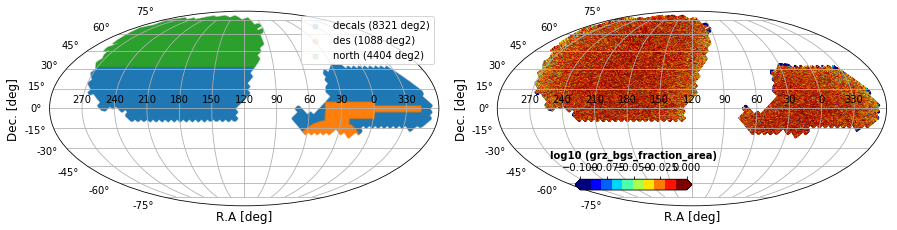

2019-11-05 19:16:27 end


In [24]:
# hp quantities diagnosis
print(raichoorlib.get_date(), 'start')

# areas
print('areas for for hp pix inside desi footprint:')
print('==============')
#hpdict['area_all']   = hpdict['bgsfracarea'].sum() * pixarea
print('dr8  = '+'%.0f'%hpdict['area_all']+' deg2')
for reg in ['south','decals','des','north']:
    print(reg+' = '+'%.0f'%hpdict['bgsarea_'+reg]+' deg2')
print('==============')

fig    = plt.figure(figsize=(15,10))
gs     = gridspec.GridSpec(1,2,wspace=0.15,hspace=0)

## plotting subregions
ax     = plt.subplot(gs[0],projection=projection)
_      = set_mwd(ax,org=org)
ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
for reg in ['decals','des','north']:
    tmp    = (hpdict['bgsfracarea']>0) & (hpdict['is'+reg])
    SC = ax.scatter(ramw[tmp],decmw[tmp],s=1,alpha=0.1,
                    label=reg+' ('+'%.0f'%hpdict['bgsarea_'+reg]+' deg2)')
ax.legend(markerscale=5)

# plotting bgsfracarea
cmin,cmax  = -0.1,0
cbarticks  = np.linspace(cmin,cmax,5)
cbar_ylab  = ['%.2f' % x for x in cbarticks]
ax     = plt.subplot(gs[1],projection=projection)
_      = set_mwd(ax,org=org)
ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
tmp        = (hpdict['bgsfracarea']>0)
SC         = ax.scatter(ramw[tmp],decmw[tmp],s=1,
    c=np.log10(hpdict['bgsfracarea'][tmp]),
    cmap=cm,vmin=cmin,vmax=cmax,rasterized=True)
# https://stackoverflow.com/questions/41428442/horizontal-colorbar-over-2-of-3-subplots
p    = ax.get_position().get_points().flatten()
cax  = fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.35*(p[3]-p[1]),0.3*(p[2]-p[0]),0.015])
cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
cbar.set_label('log10 (grz_bgs_fraction_area)',fontweight='bold')
cbar.ax.set_yticklabels(cbar_ylab)
plt.show()
plt.close()

print(raichoorlib.get_date(), 'end')


## r Vs rfibmag 

In [14]:
from main_def import hexbin, get_reg

In [15]:
iscatsouth = get_reg(reg='south', hppix=hppix_cat)

In [21]:
finite = np.ones_like(cat['RMAG'], dtype='?')
for i in ['RMAG', 'GMAG', 'ZMAG','FLUX_R', 'RFIBMAG']:
    finite &= np.isfinite(cat[i])

/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


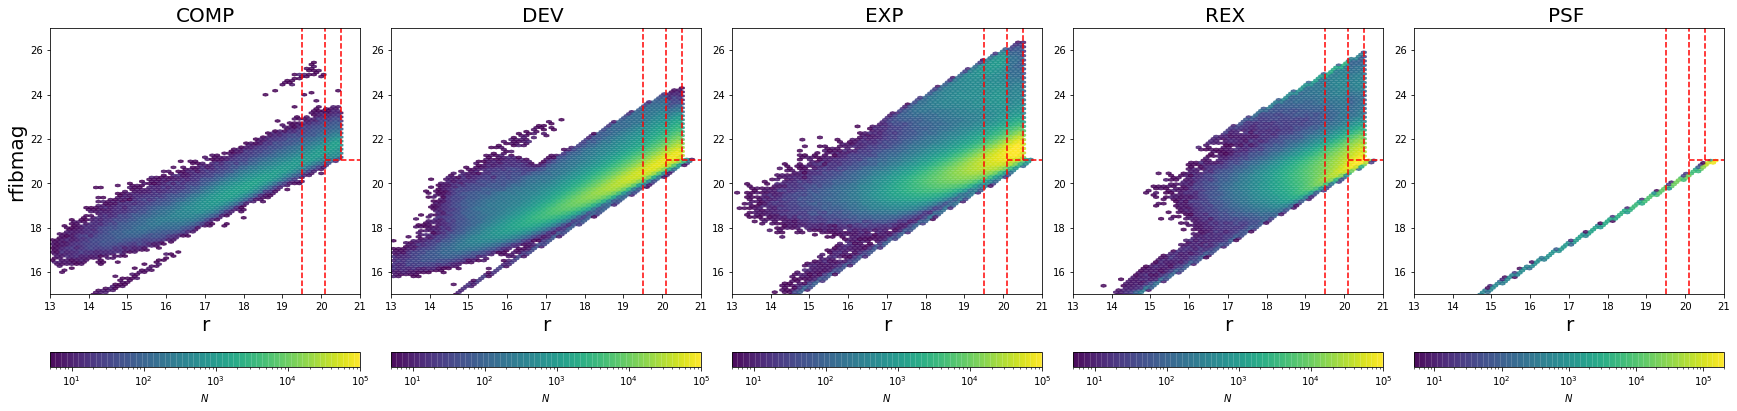

In [32]:
coord = {'r':cat['RMAG'], 'rfibmag':cat['RFIBMAG']}
morphos = ['COMP', 'DEV ', 'EXP ', 'REX ', 'PSF ']
#morphos = ['REX ']
mask = (iscatsouth) & (finite) & (maskdef_cat)
hline, vline = None, None
vmin, vmax = 5, 100000
    
fig    = plt.figure(figsize=(6*len(morphos),7))
gs     = gridspec.GridSpec(1,len(morphos),hspace=0.10,wspace=0.10)
    
for i, morpho in enumerate(morphos):
    
    if (i%len(morphos)==0): ylab=True
    else: ylab = False
    if morpho == 'PSF ': vmax = None
        
    morphomask = cat['MORPHTYPE'] == morpho
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=morpho, cmap='viridis', 
               ylab=ylab, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=vmin, 
                   xlim=(13, 21.), ylim=(15, 27))
    
    ax = fig.add_subplot(gs[i])
    ax.axvline(19.5, ls='--', c='r')
    ax.axvline(20.1, ls='--', c='r')
    ax.plot(np.linspace(20.1, 21, 3), np.full(3, 21.051), ls='--', c='r')
    ax.plot(np.full(3, 20.5), np.linspace(21.051, 27, 3), ls='--', c='r')
    

## Load BGS SV data and get target densities + sanity check

Now we move to our target catalogue `bgssvdr8` and compute the number of targets in the healpix pixels for each of the SV supersets (bright/faint/faint_ext/fibmag/lowq) and for the nort/south regions. The target density is defined as $\eta_{pix}^{bgs}(bit) = N_{pix}^{bgs}(bit)/(A_{pix} \cdot f_{A})$. Finally we get the mean density ($\bar{\eta}_{pix}^{bgs}(bit)$) and add this to the `hpdict`.

To select the sv bits we use the `SV1_BGS_TARGET` information from DESITARGET. The bits and bitvalues key is below:

    name	       bitnums	bitvals
    BGS_FAINT	    0	        1
    BGS_BRIGHT	   1	        2
    BGS_FAINT_EXT    2	        4
    BGS_LOWQ	     3	        8
    BGS_FIBMAG	   4	       16
    
To make sure we haven't mess things around, we run a sanity check with a random subsample of $1$%. We make colour plots of $g-r$, $r-z$ and scatter plots of $rmag$ vs $rfibmag$ plus their distributions for all the SV bits and for each of the nort/south regions.

2019-10-30 20:31:36 start
1207 nearby objects
computing for  north / any
computing for  north / bright
computing for  north / faint
computing for  north / faint_ext
computing for  north / fibmag
computing for  north / lowq
plotting for  north / any
plotting for  north / bright
plotting for  north / faint
plotting for  north / faint_ext
plotting for  north / fibmag
plotting for  north / lowq


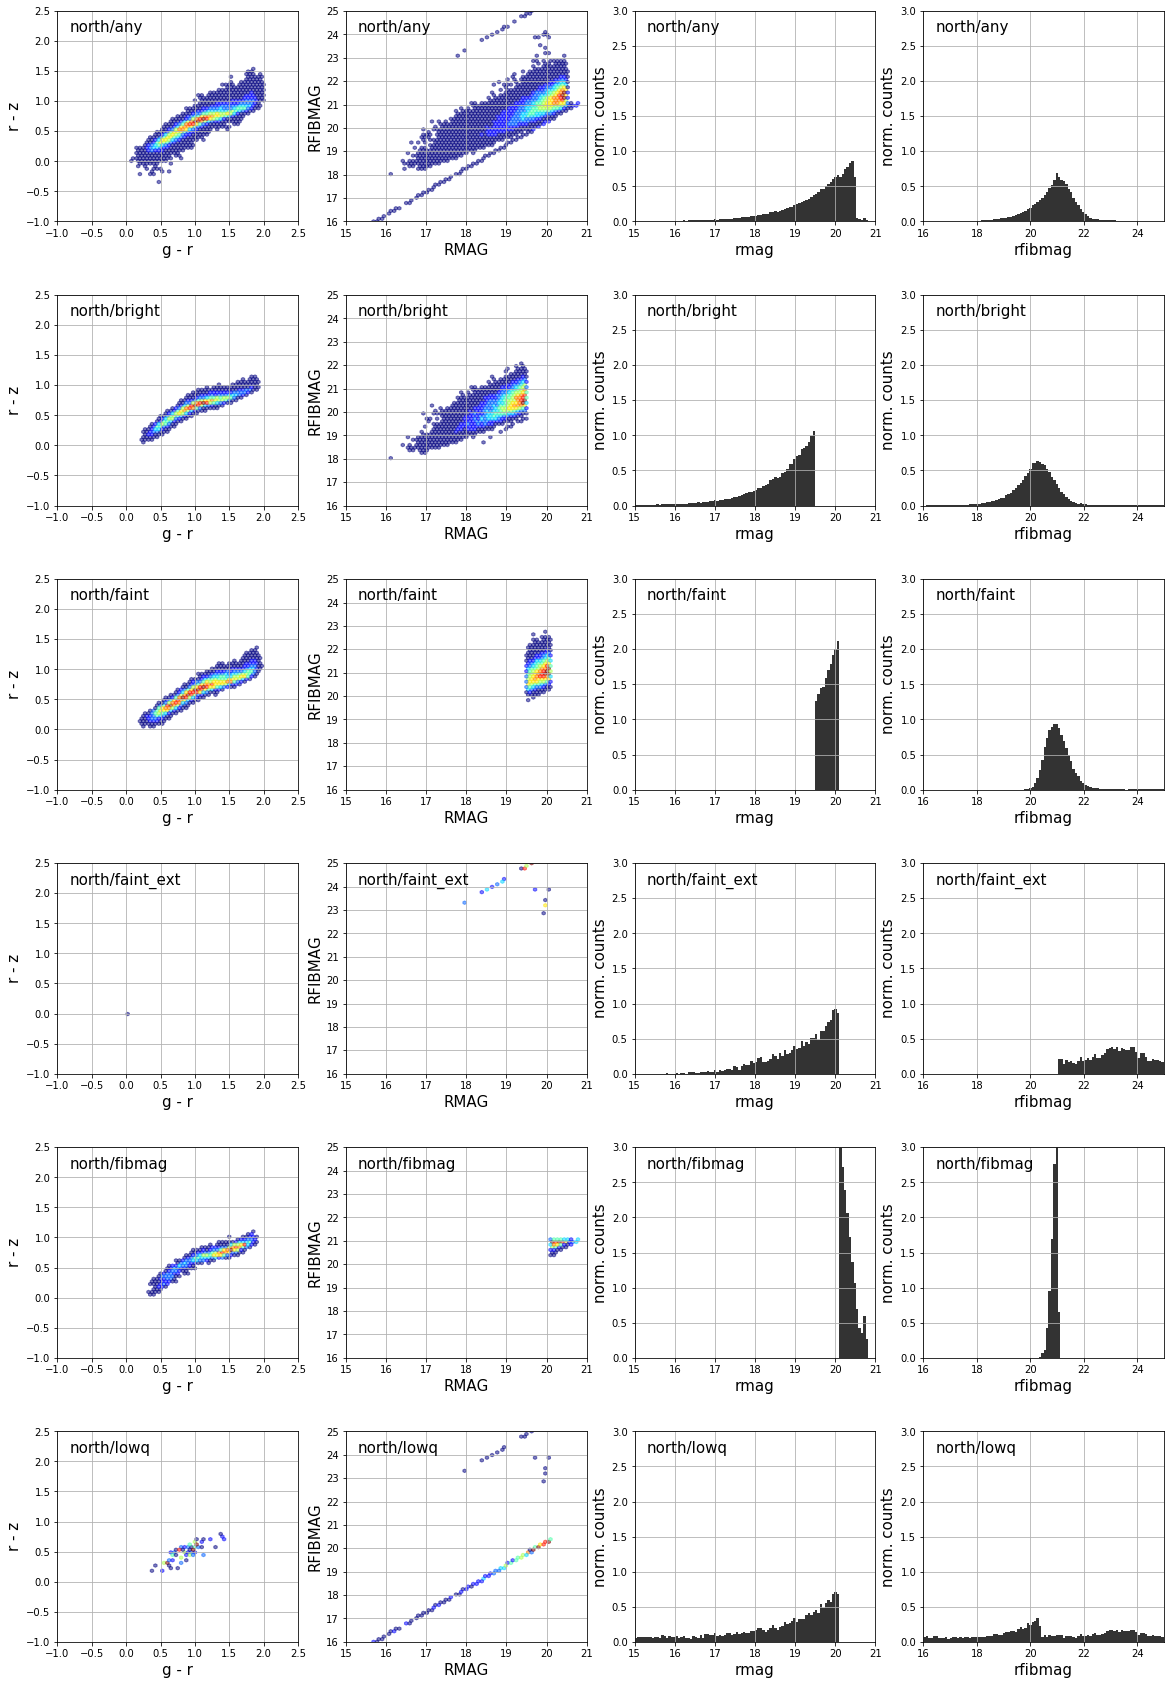

1207 nearby objects
computing for  south / any
computing for  south / bright
computing for  south / faint
computing for  south / faint_ext
computing for  south / fibmag
computing for  south / lowq
plotting for  south / any
plotting for  south / bright
plotting for  south / faint
plotting for  south / faint_ext
plotting for  south / fibmag
plotting for  south / lowq


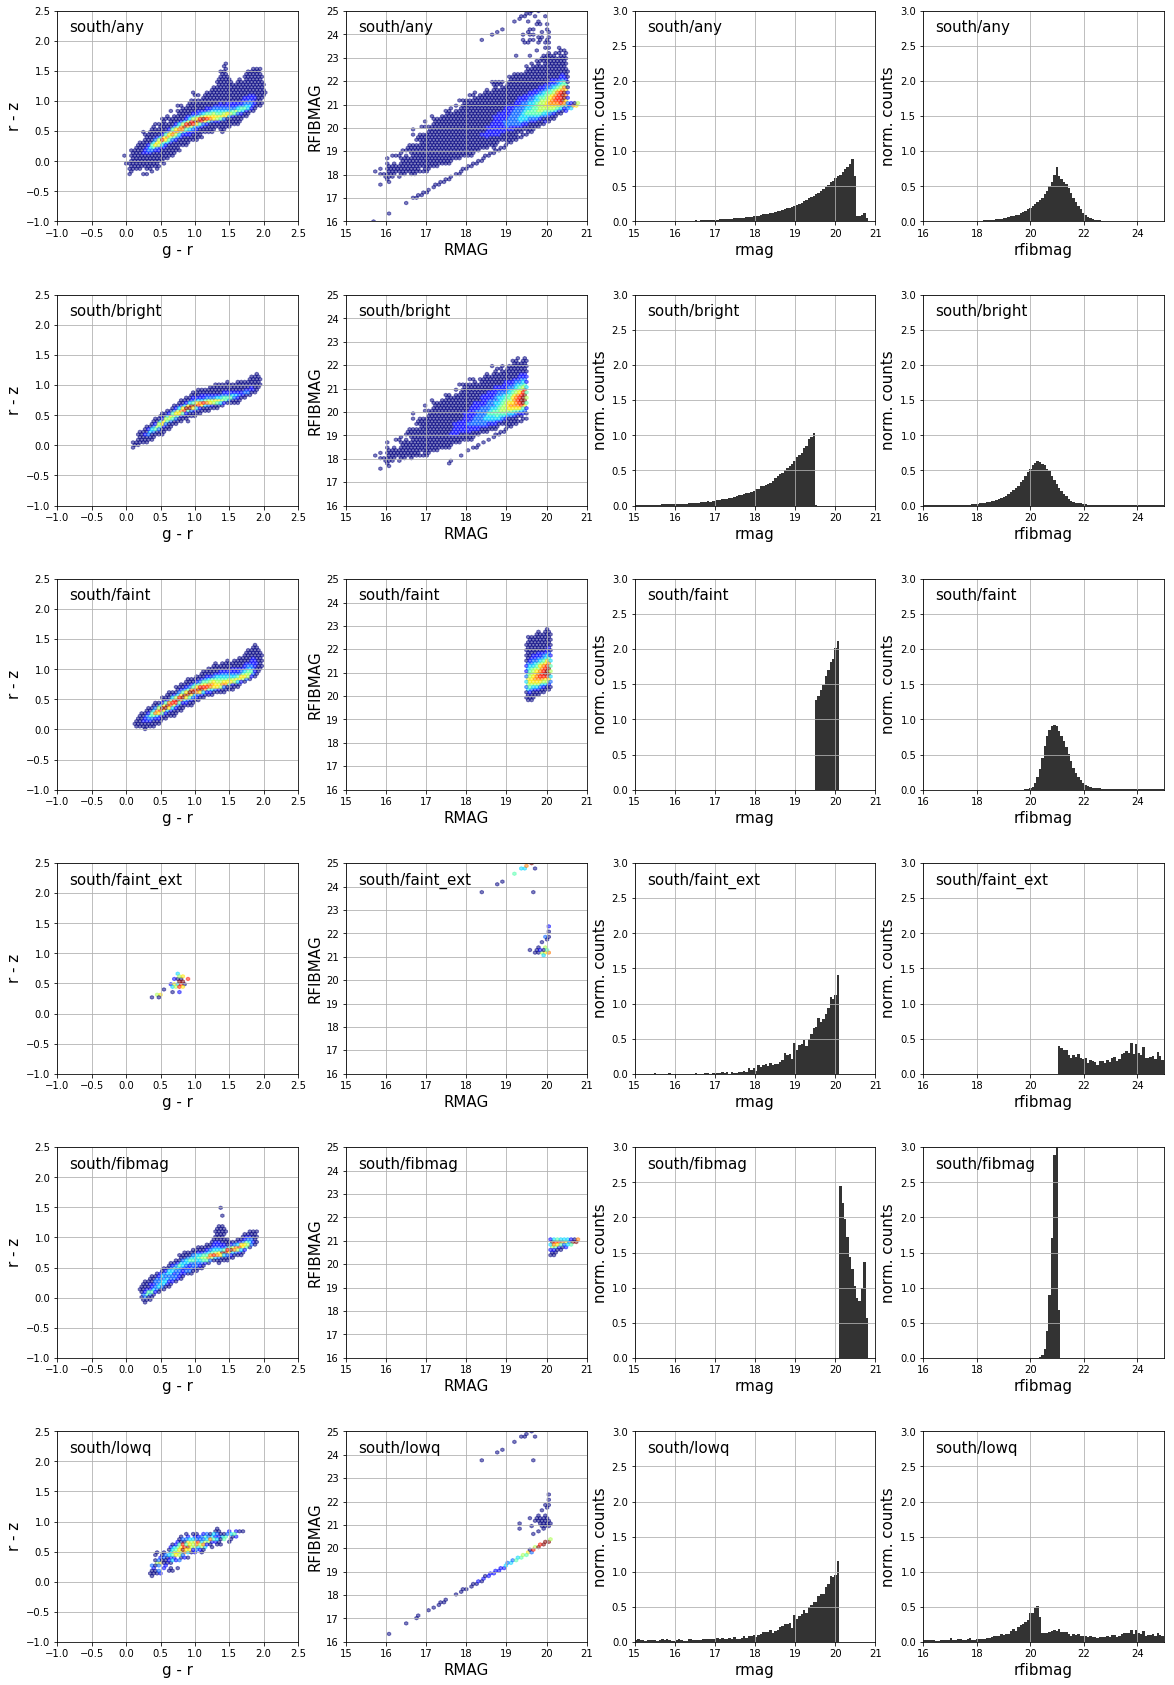

any
meandens_any_all = 2551 /deg2
meandens_any_des = 2467 /deg2
meandens_any_decals = 2561 /deg2
meandens_any_north = 2554 /deg2
bright
meandens_bright_all = 845 /deg2
meandens_bright_des = 855 /deg2
meandens_bright_decals = 852 /deg2
meandens_bright_north = 830 /deg2
faint
meandens_faint_all = 736 /deg2
meandens_faint_des = 738 /deg2
meandens_faint_decals = 738 /deg2
meandens_faint_north = 732 /deg2
faint_ext
meandens_faint_ext_all = 624 /deg2
meandens_faint_ext_des = 622 /deg2
meandens_faint_ext_decals = 622 /deg2
meandens_faint_ext_north = 629 /deg2
fibmag
meandens_fibmag_all = 215 /deg2
meandens_fibmag_des = 207 /deg2
meandens_fibmag_decals = 236 /deg2
meandens_fibmag_north = 179 /deg2
lowq
meandens_lowq_all = 131 /deg2
meandens_lowq_des = 46 /deg2
meandens_lowq_decals = 114 /deg2
meandens_lowq_north = 185 /deg2
2019-10-30 20:33:10 end


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: invalid value encountered in true_divide


In [8]:
# dr8_south+north : read sv data + sanity check + storing mean hpdens 
print(raichoorlib.get_date(), 'start')

#target densities
data = np.load(inptfiles['bgssvdr8'])

# subsamples (BGS SV supersets)
#namesels = {'any':-1, 'bright':1, 'faint':0, 'faint_ext':2, 'fibmag':4, 'lowq':3}

for foot in ['north','south']:

    ## cutting on desi footprint
    keep = get_isdesi(data['RA'],data['DEC'])
    ## cutting on dec_resol_ns in the ngc
    c    = SkyCoord(data['RA']*units.degree,data['DEC']*units.degree, frame='icrs')
    galb = c.galactic.b.value
    if (foot=='north'):
        keep&= (data['DEC']>dec_resol_ns) & (galb>0)
    if (foot=='south'):
        keep&= (data['DEC']<dec_resol_ns) | (galb<0)        
    ##
    data0 = data[keep]

    # storing density in hpdict
    hppix           = hp.ang2pix(nside,(90.-data0['DEC'])*np.pi/180.,data0['RA']*np.pi/180.,nest=nest)
    for namesel, bitnum in zip(namesels.keys(), namesels.values()):
        print('computing for ', foot, '/', namesel)
        if (namesel=='any'):             sel = np.ones(len(data0),dtype=bool)
        elif (namesel=='faint_ext'):     sel = (((data0['SV1_BGS_TARGET'] & 2**(bitnum)) != 0)) & (data0['RFIBMAG'] > 21.0511) #fix overlap
        else:                            sel = ((data0['SV1_BGS_TARGET'] & 2**(bitnum)) != 0)
            
        ind,c           = np.unique(hppix[sel],return_counts=True)
        hpdict[foot+'_n'+namesel]      = np.zeros(npix)
        hpdict[foot+'_n'+namesel][ind] = c

    # plotting (sanity checks with 1%)
    fracplot   = 0.01
    selplot    = np.zeros(len(data0),dtype=bool)
    selplot[np.random.choice(len(data0),size=int(fracplot*len(data0)),replace=False)] = True
    fig        = plt.figure(figsize=(25,30))
    gs         = gridspec.GridSpec(len(namesels),5,wspace=0.2,hspace=0.35)
    # mollweide
    ramw,decmw = get_radec_mw(data0['RA'],data0['DEC'],org)
    ax         = plt.subplot(gs[0,:],projection=projection)
    _          = set_mwd(ax,org=org)
    SC         = ax.scatter(ramw[selplot],decmw[selplot],s=0.01,rasterized=True)
    
    for ip,namesel in enumerate(namesels.keys()):
        print('plotting for ', foot, '/', namesel)
        sellab = foot+'/'+namesel
        if (namesel=='any'):             sel = np.ones(len(data0),dtype=bool)
        elif (namesel=='faint_ext'):     sel = (((data0['SV1_BGS_TARGET'] & 2**(bitnum)) != 0)) & (data0['RFIBMAG'] > 21.0511) #fix overlap
        else:                            sel = ((data0['SV1_BGS_TARGET'] & 2**(namesels[namesel])) != 0)
        sel &= (selplot) # subsampling
        
        # grz
        ax = plt.subplot(gs[ip,0])

        gr = data0['GMAG'] - data0['RMAG']
        rz = data0['RMAG'] - data0['ZMAG']
        ylim,ylab = (-1,2.5),'r - z'
        xlim,xlab = (-1,2.5),'g - r'
        HB = ax.hexbin(gr[sel],rz[sel],C=None,
                gridsize=70,extent=(xlim[0],xlim[1],ylim[0],ylim[1]),cmap=cm,mincnt=10,
                alpha=0.5)
        ax.set_xlabel(xlab,fontsize=15)
        ax.set_ylabel(ylab,fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(True)
        ax.text(0.05,0.90,sellab,fontsize=15,transform=ax.transAxes)
        
        # coii-g
        ax = plt.subplot(gs[ip,1])
        xlim,xlab = (15,21),'RMAG'
        ylim,ylab = (16,25),'RFIBMAG'
        HB = ax.hexbin(data0['RMAG'][sel],data0['RFIBMAG'][sel],C=None,
                gridsize=70,extent=(xlim[0],xlim[1],ylim[0],ylim[1]),cmap=cm,mincnt=10,
                alpha=0.5)
        ax.set_xlabel(xlab,fontsize=15)
        ax.set_ylabel(ylab,fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(True)
        ax.text(0.05,0.90,sellab,fontsize=15,transform=ax.transAxes)
        
        # gtot hist
        xlim  = (15,21)
        xgrid = np.linspace(xlim[0],xlim[1],101)
        ax = plt.subplot(gs[ip,2])
        ax.hist(data0['RMAG'][sel],bins=xgrid,histtype='stepfilled',alpha=0.8,color='k',density=True)
        ax.set_xlabel('rmag',fontsize=15)
        ax.set_ylabel('norm. counts',fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(0,3)
        ax.grid(True)
        ax.text(0.05,0.90,sellab,fontsize=15,transform=ax.transAxes)
        # gfib hist
        xlim  = (16,25)
        xgrid = np.linspace(xlim[0],xlim[1],101)
        ax = plt.subplot(gs[ip,3])
        ax.hist(data0['RFIBMAG'][sel],bins=xgrid,histtype='stepfilled',alpha=0.8,color='k',density=True)
        ax.set_xlabel('rfibmag',fontsize=15)
        ax.set_ylabel('norm. counts',fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(0,3)
        ax.grid(True)
        ax.text(0.05,0.90,sellab,fontsize=15,transform=ax.transAxes)
        #
    plt.show()
    plt.close()


# storing mean hpdens
isdesi = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
for namesel in namesels.keys():
    print(namesel)
    ## south + north density
    hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])
    ## split per region
    for reg in ['all','des','decals','north']:
        if (reg=='all'):
            hpdict['meandens_'+namesel+'_'+reg] = np.nanmean(hpdens[isdesi])
        else:
            hpdict['meandens_'+namesel+'_'+reg] = np.nanmean(hpdens[(isdesi) & (hpdict['is'+reg])])
        print('meandens_'+namesel+'_'+reg+' = '+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+' /deg2')

#print(np.sort(hpdict.keys()))

print(raichoorlib.get_date(), 'end')

## Results: systematics

### Defining limits in systematics

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


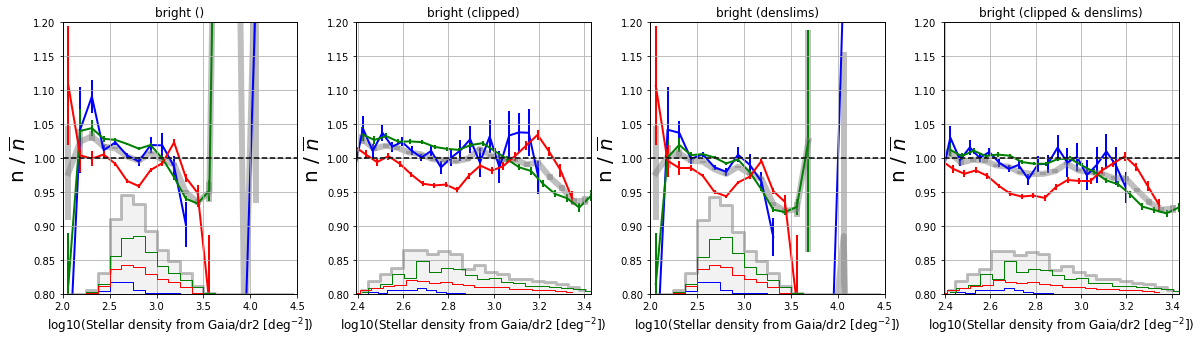

In [9]:
#
isdesi    = (hpdict['bgsfracarea']>0) & (hpdict['isdesi'])
namesels = ['bright', 'faint', 'faint_ext', 'fibmag']
xlims = [[2.2, 3.6],[2.4, 3.7], [2, 4.0], [2, 4.5]]
conblims = [[False, False], [True, False], [False, True], [True, True]]

fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1,4,hspace=0.30,wspace=0.25)

for i,j in enumerate(conblims):
    
    plot_sysdens(namesel='bright', syst='stardens', mainreg=isdesi, xlim=[2.0, 4.5], n=i, nx=20, clip=j[0], denslims=j[1])


Shall we compute $\bar{\eta}$ on the fly using the limits of the plots? At the moment it uses the stored values in hpdict and those only have the desifotprint limits and bgsfracarea > 0.

### Sky target density + systematics per BGS SV superset

plotting density distributions + systematics for the  bright selection


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


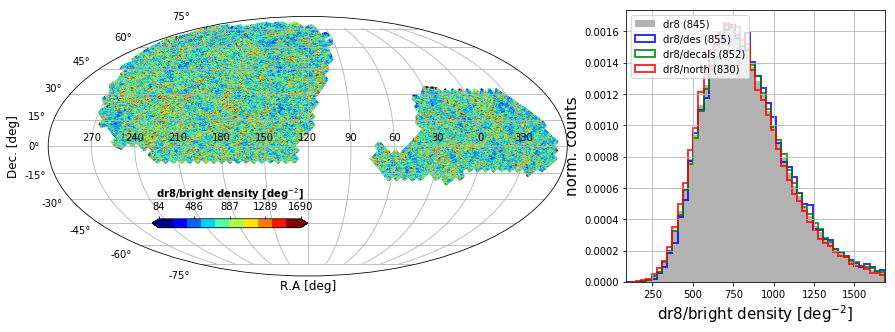

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less




plotting density distributions + systematics for the  faint selection


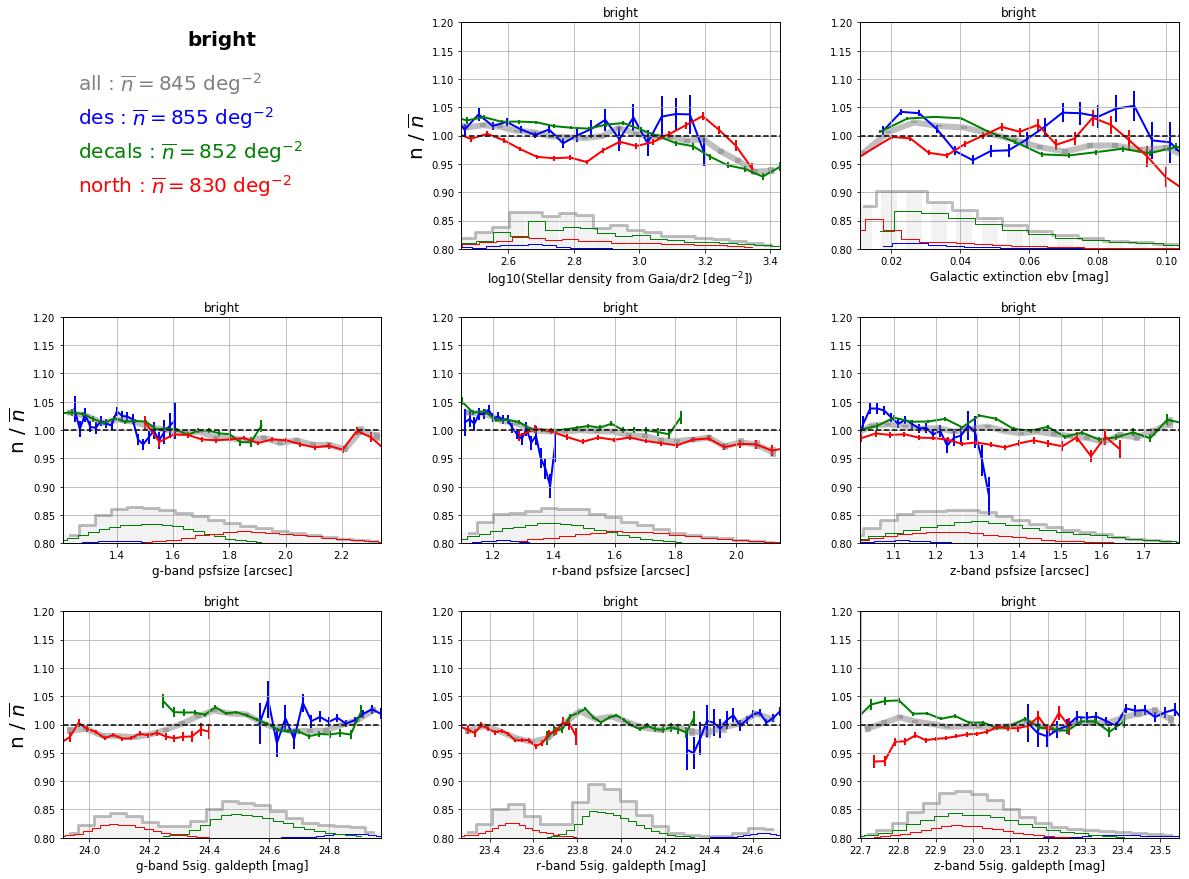

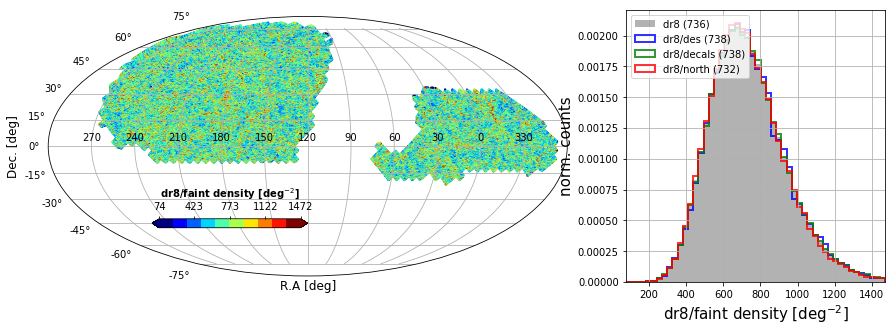



plotting density distributions + systematics for the  faint_ext selection


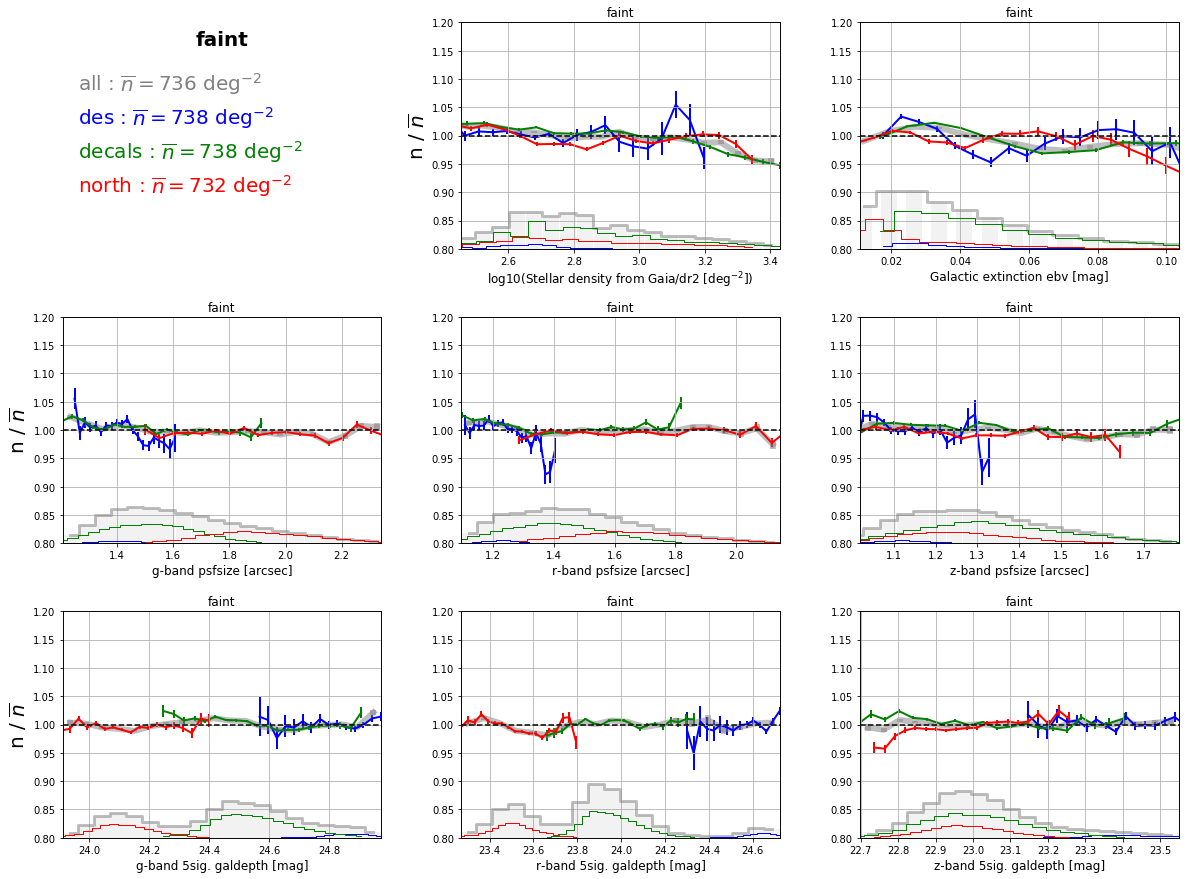

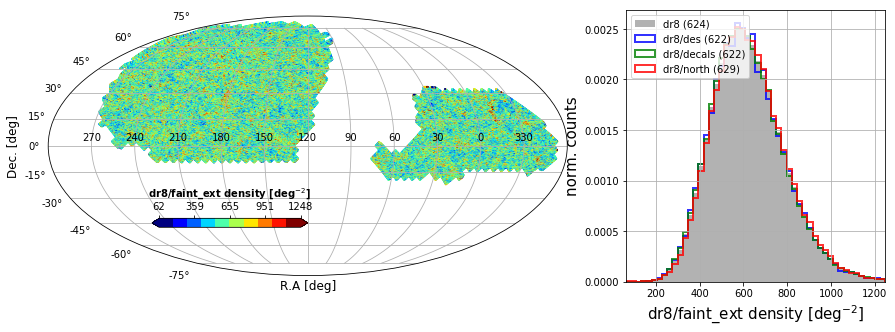



plotting density distributions + systematics for the  fibmag selection


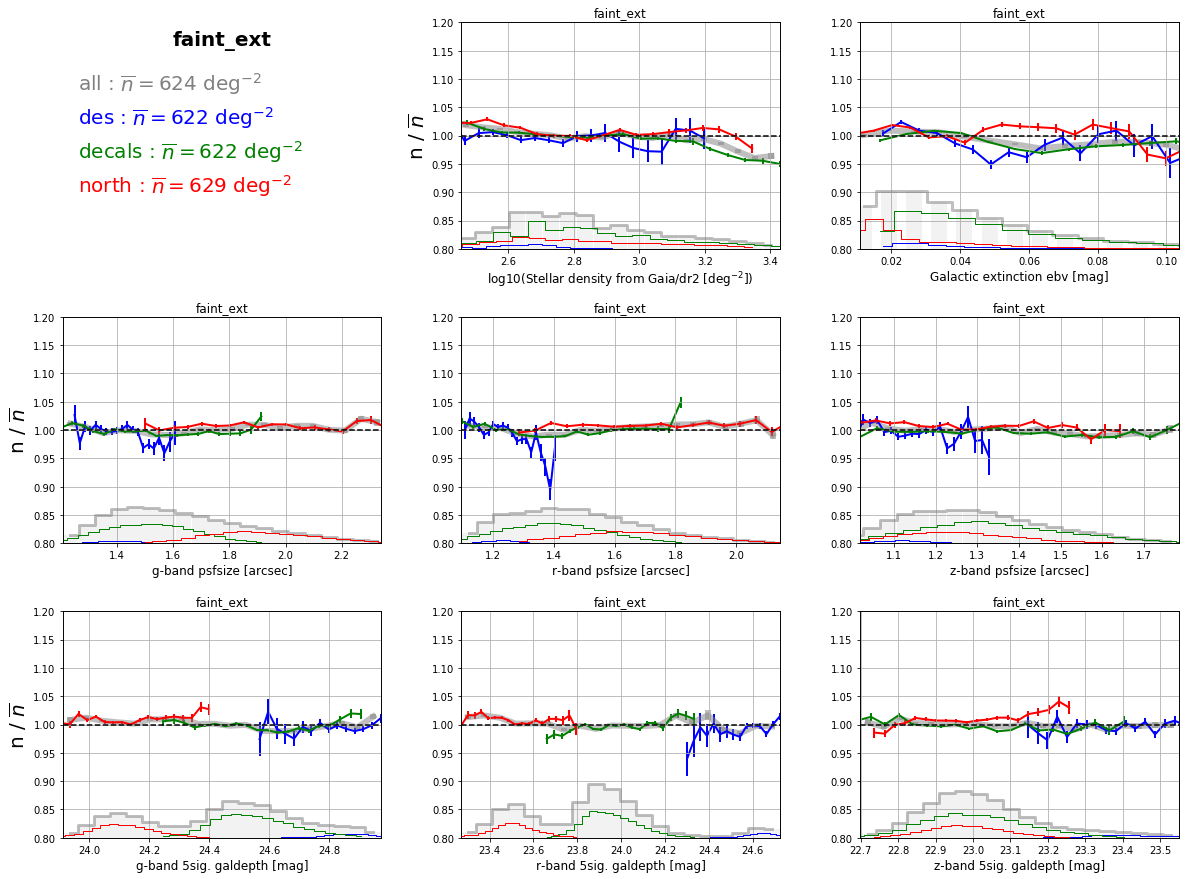

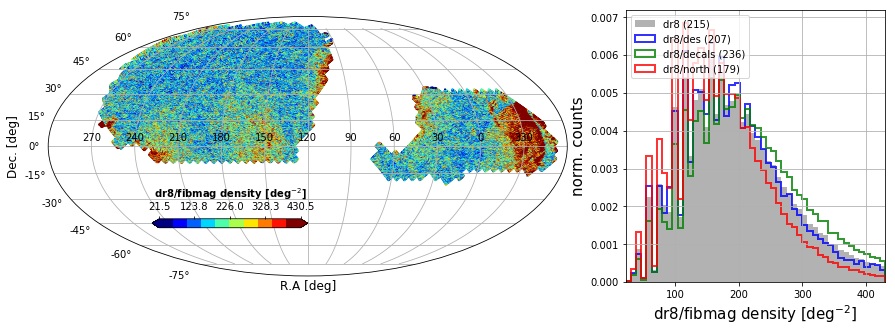



plotting density distributions + systematics for the  lowq selection


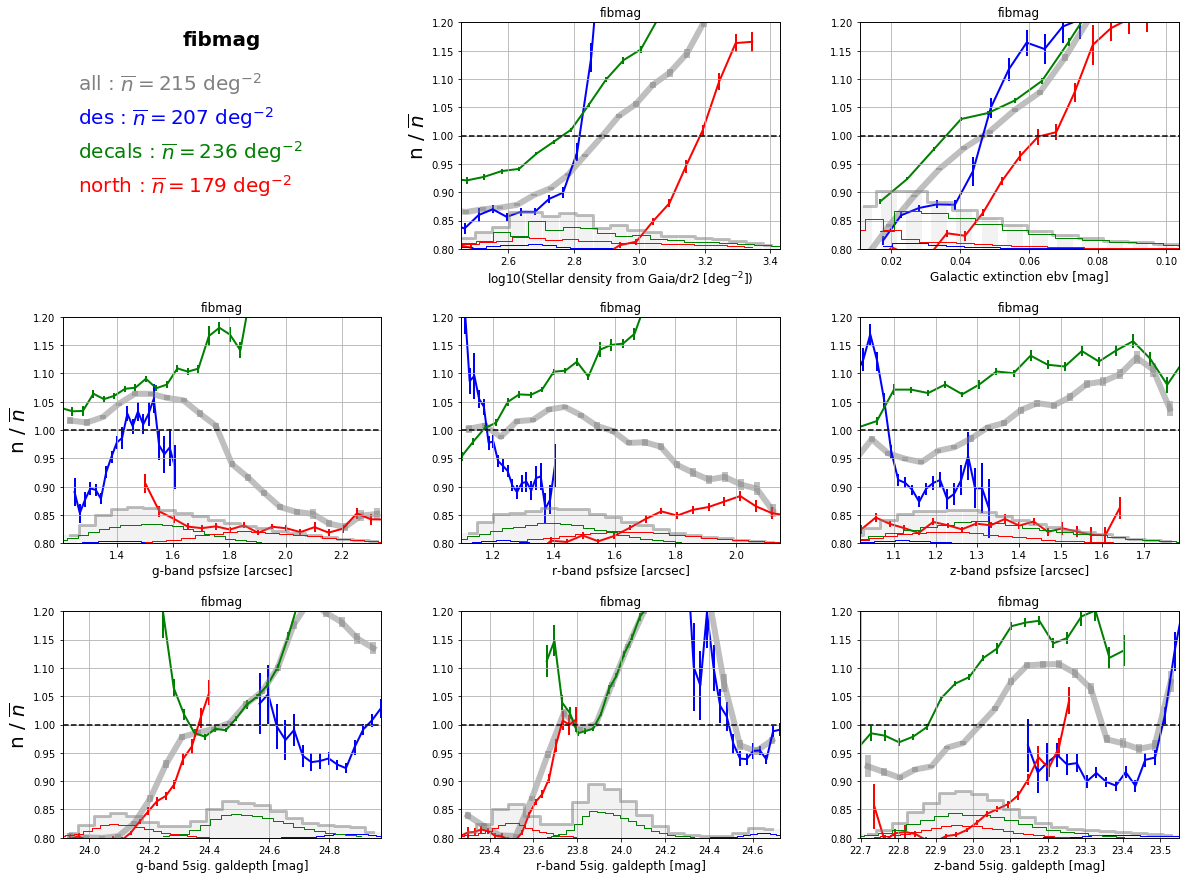

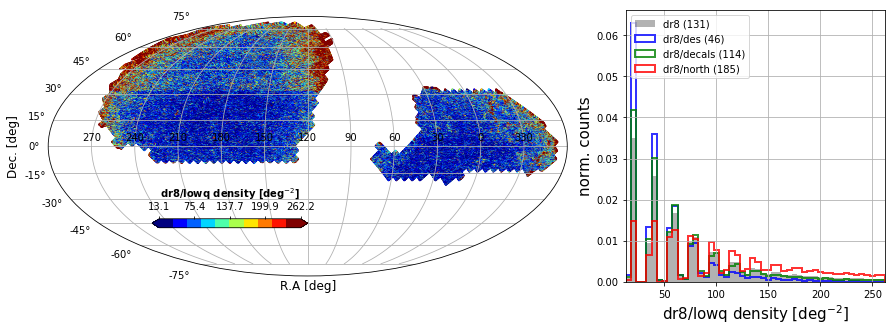

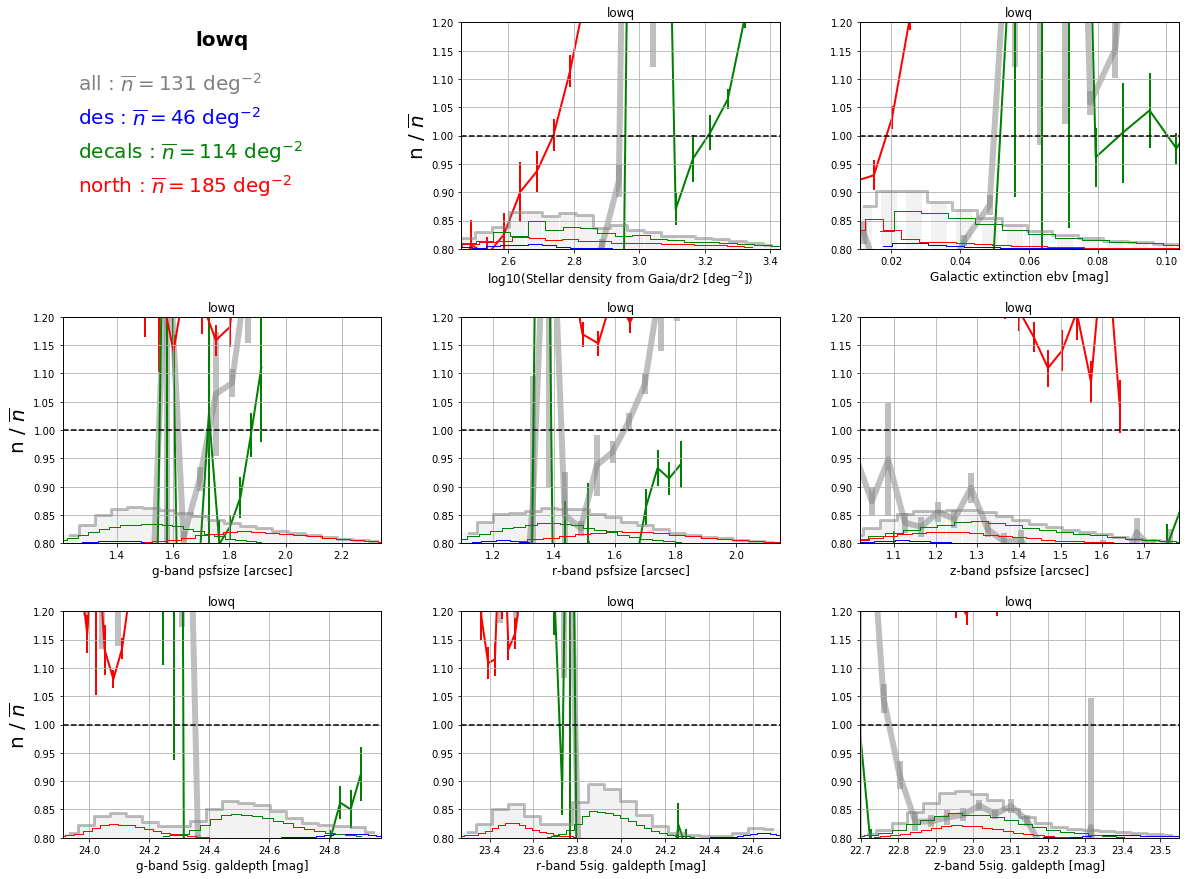

In [26]:
# dr8_south+north : density distributions + systematics
#print(raichoorlib.get_date(), 'start')

# subsamples (BGS SV supersets)
namesels = ['bright', 'faint', 'faint_ext', 'fibmag', 'lowq']
#namesels = ['bright']

# settings
ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
densmin,densmax = 0,2
regs       = ['all','des','decals','north']
cols       = ['0.5','b','g','r']

# looping on subselections
for namesel in namesels:
    
    print('plotting density distributions + systematics for the ', namesel, 'selection')
    
    hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])
    hpmean = hpdict['meandens_'+namesel+'_all']
    cmin,cmax = (0.1*hpmean,2*hpmean)
    cbarticks = np.linspace(cmin,cmax,5)
    cbar_ylab = ['%.0f' % x for x in cbarticks]
    clab      = 'dr8/'+namesel+r' density [deg$^{-2}$]'

    # density skymap + hist
    fig        = plt.figure(figsize=(15,5))
    gs         = gridspec.GridSpec(1,2,wspace=0.15,hspace=0.3,width_ratios=[2,1])
    # mollweide
    ax     = plt.subplot(gs[0],projection=projection)
    _      = set_mwd(ax,org=org)
    SC  = ax.scatter(ramw[isdesi],decmw[isdesi],s=1,
        c=hpdens[isdesi],
        cmap=cm,vmin=cmin,vmax=cmax,rasterized=True)
    p  = ax.get_position().get_points().flatten()
    cax= fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.2*(p[3]-p[1]),0.3*(p[2]-p[0]),0.025])
    cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
    cbar.set_label(clab,fontweight='bold')
    cbar.ax.set_yticklabels(cbar_ylab)
    # hist
    ax     = plt.subplot(gs[1])
    xgrid  = np.linspace(cmin,cmax,51)
    ax.hist(hpdens[isdesi],
            bins=xgrid,histtype='stepfilled',alpha=0.3,color='k',density=True,
            label='dr8 ('+'%.0f'%hpdict['meandens_'+namesel+'_all']+')')
    for reg,col in zip(regs[1:],cols[1:]):
        tmp    = (isdesi) & (hpdict['is'+reg])
        ax.hist(hpdens[tmp],
                bins=xgrid,histtype='step',alpha=0.8,color=col,lw=2,density=True,
                label='dr8/'+reg+' ('+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+')')
    ax.set_xlabel(clab,fontsize=15)
    ax.set_ylabel('norm. counts',fontsize=15)
    ax.set_xlim(cmin,cmax)
    #ax.set_ylim(0,5)
    ax.grid(True)
    ax.legend(ncol=1,loc=2)
    plt.show()
    plt.close()
            
    # systematics
    fig    = plt.figure(figsize=(20,15))
    gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
        
    for i in range(len(systs)+1):
        
        if i == 0:
            axinfo = fig.add_subplot(gs[i])
            # infos
            axinfo.axis('off')
            axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
            tmpy = 0.7
            for reg,col in zip(regs,cols):
                tmpstr = reg+' : '+r'$\overline{n}=$'+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
                axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=20,transform=axinfo.transAxes)
                tmpy  -= 0.15
        else:
            syst = systs[i-1]
            if (i%3==0) or (i==1): ylab=True
            else: ylab = False
            plot_sysdens(hpdicttmp=hpdict, namesel=namesel, syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, denslims=False, ylab=ylab)
        
    print('')
    print('')

### comparing systematics per BGS SV superset

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less


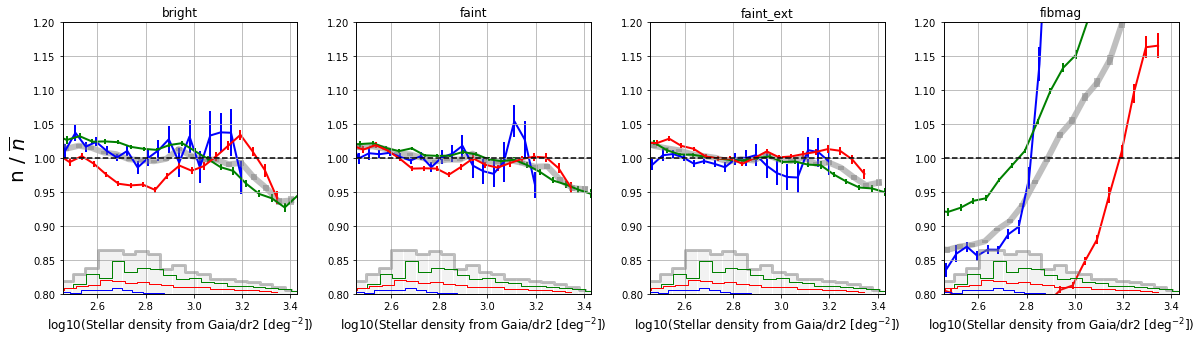

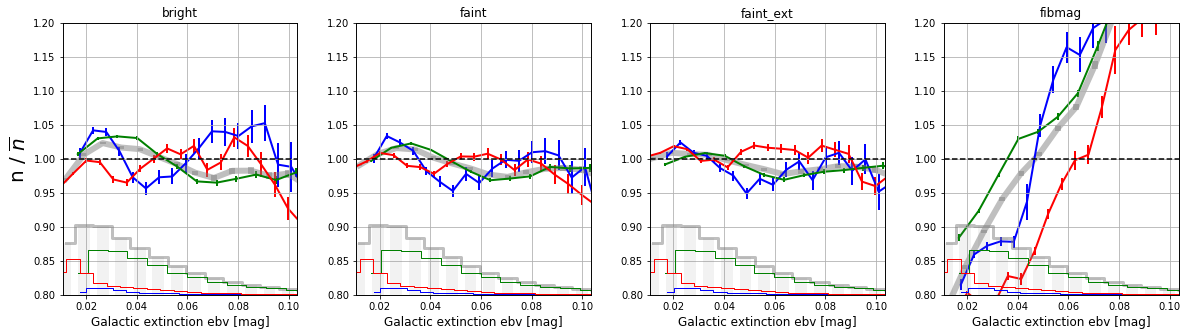

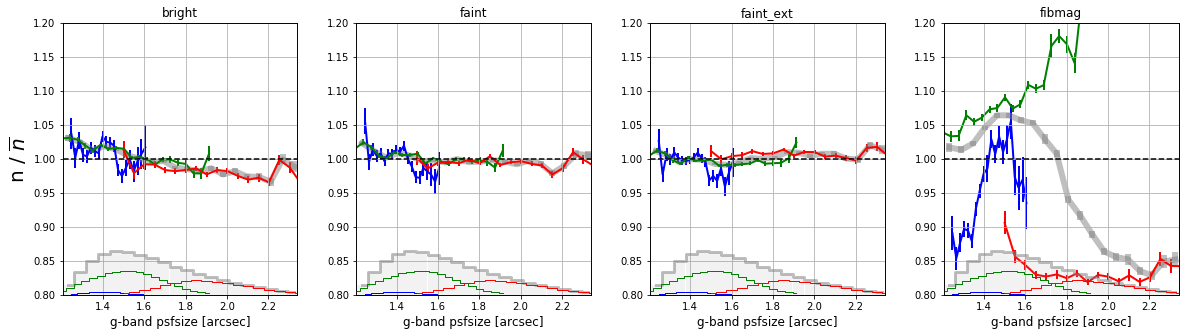

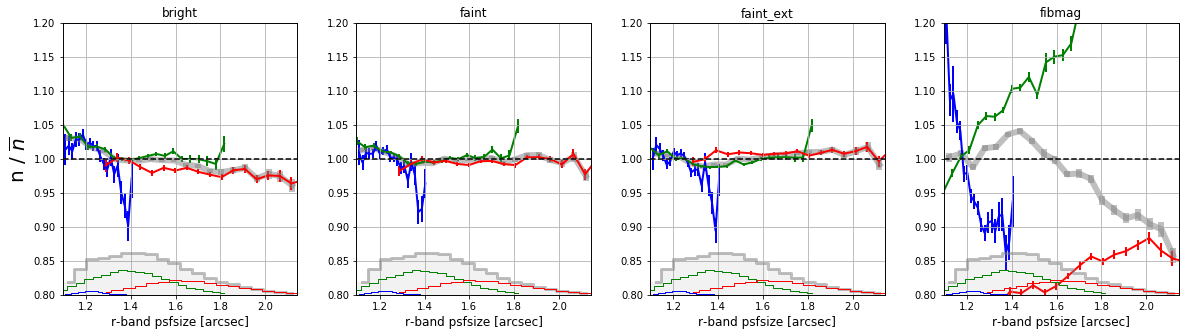

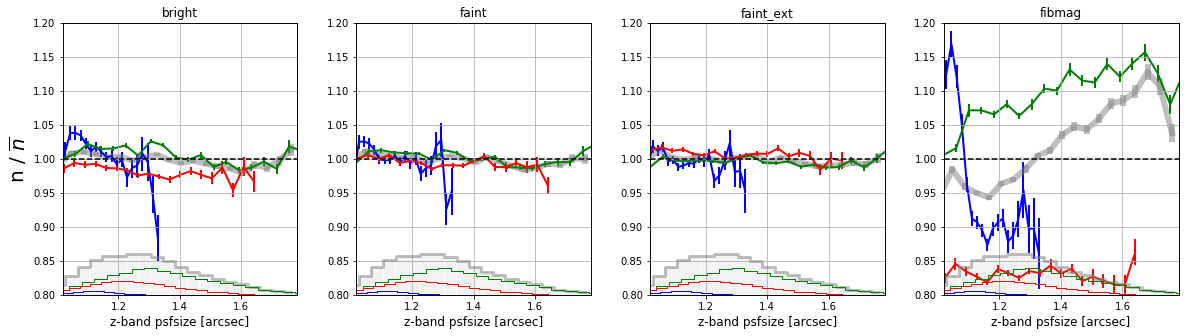

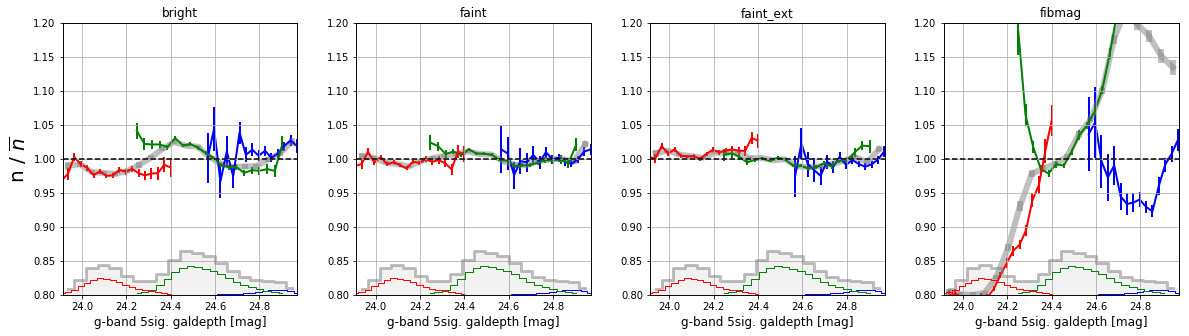

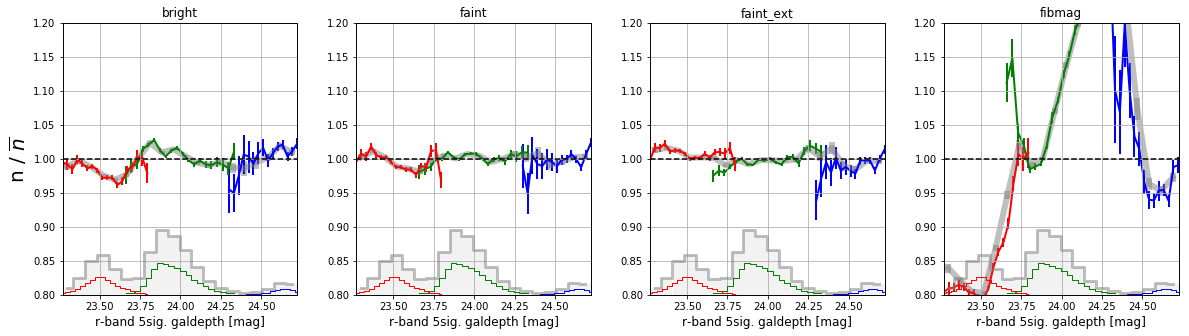

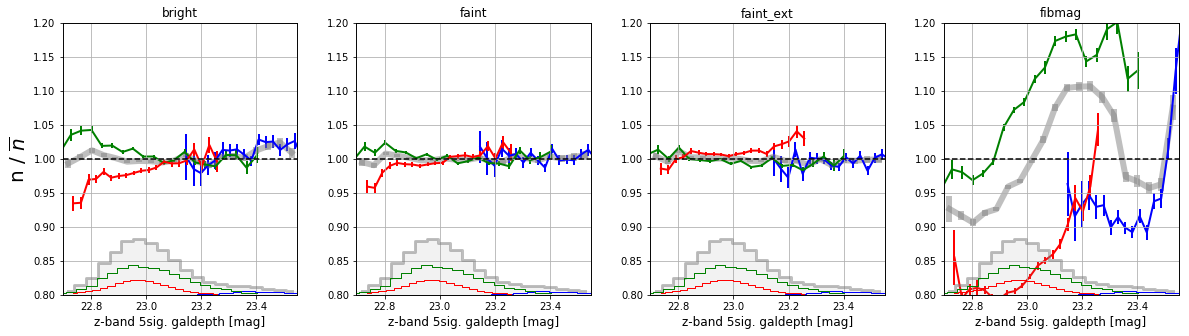

In [27]:
# systematics
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
#systs      = ['stardens','ebv','psfsize_g']
nx         = 20
namesels = ['bright', 'faint', 'faint_ext', 'fibmag']
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
#isbgsfield    = (hpdict['bgsfracarea']>0) & (hpdict['isbgsfield'])

for j in range(len(systs)):
    
    fig    = plt.figure(figsize=(5*len(namesels),5))
    gs     = gridspec.GridSpec(1,len(namesels),hspace=0.30,wspace=0.25)
    syst = systs[j]
    
    for i, namesel in enumerate(namesels):
        
        if (i%4==0): ylab=True
        else: ylab = False
        plot_sysdens(hpdicttmp=hpdict, namesel=namesel, syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, denslims=False, ylab=ylab)
        

# BGS SV fields

In [10]:
tiles = fitsio.read(inptfiles['bgssvtiles'])

hpdict['isbgsfield'], tileid = get_isbgstile(hpdict['ra'],hpdict['dec'])

# areas in BGS SV fiels
hpdict['bgsfield_area_all']   = hpdict['bgsfracarea'][hpdict['isbgsfield']].sum() * pixarea
for reg in ['south','decals','des','north']:
    hpdict['bgsfield_area_'+reg]   = hpdict['bgsfracarea'][(hpdict['is'+reg]) & (hpdict['isbgsfield'])].sum() * pixarea
    
# subsamples (BGS SV supersets)
namesels = {'any':-1, 'bright':1, 'faint':0, 'faint_ext':2, 'fibmag':4, 'lowq':3}
# storing mean hpdens
mask = (hpdict['isbgsfield']) & (hpdict['bgsfracarea']>0)
for namesel in namesels.keys():
    print(namesel)
    ## south + north density
    hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])
    ## split per region
    for reg in ['all','des','decals','north', 'south']:
        if (reg=='all'):
            hpdict['meandens_svfields_'+namesel+'_'+reg] = np.nanmean(hpdens[mask])
        else:
            hpdict['meandens_svfields_'+namesel+'_'+reg] = np.nanmean(hpdens[(mask) & (hpdict['is'+reg])])
        print('meandens_svfields_'+namesel+'_'+reg+' = '+'%.0f'%hpdict['meandens_svfields_'+namesel+'_'+reg]+' /deg2')


9201 nearby objects
any
meandens_svfields_any_all = 2503 /deg2
meandens_svfields_any_des = 2469 /deg2
meandens_svfields_any_decals = 2501 /deg2
meandens_svfields_any_north = 2523 /deg2
meandens_svfields_any_south = 2498 /deg2
bright
meandens_svfields_bright_all = 849 /deg2
meandens_svfields_bright_des = 871 /deg2
meandens_svfields_bright_decals = 851 /deg2
meandens_svfields_bright_north = 832 /deg2
meandens_svfields_bright_south = 853 /deg2
faint
meandens_svfields_faint_all = 735 /deg2
meandens_svfields_faint_des = 736 /deg2
meandens_svfields_faint_decals = 736 /deg2
meandens_svfields_faint_north = 734 /deg2
meandens_svfields_faint_south = 736 /deg2
faint_ext
meandens_svfields_faint_ext_all = 617 /deg2
meandens_svfields_faint_ext_des = 610 /deg2
meandens_svfields_faint_ext_decals = 616 /deg2
meandens_svfields_faint_ext_north = 625 /deg2
meandens_svfields_faint_ext_south = 615 /deg2
fibmag
meandens_svfields_fibmag_all = 208 /deg2
meandens_svfields_fibmag_des = 206 /deg2
meandens_svfield

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


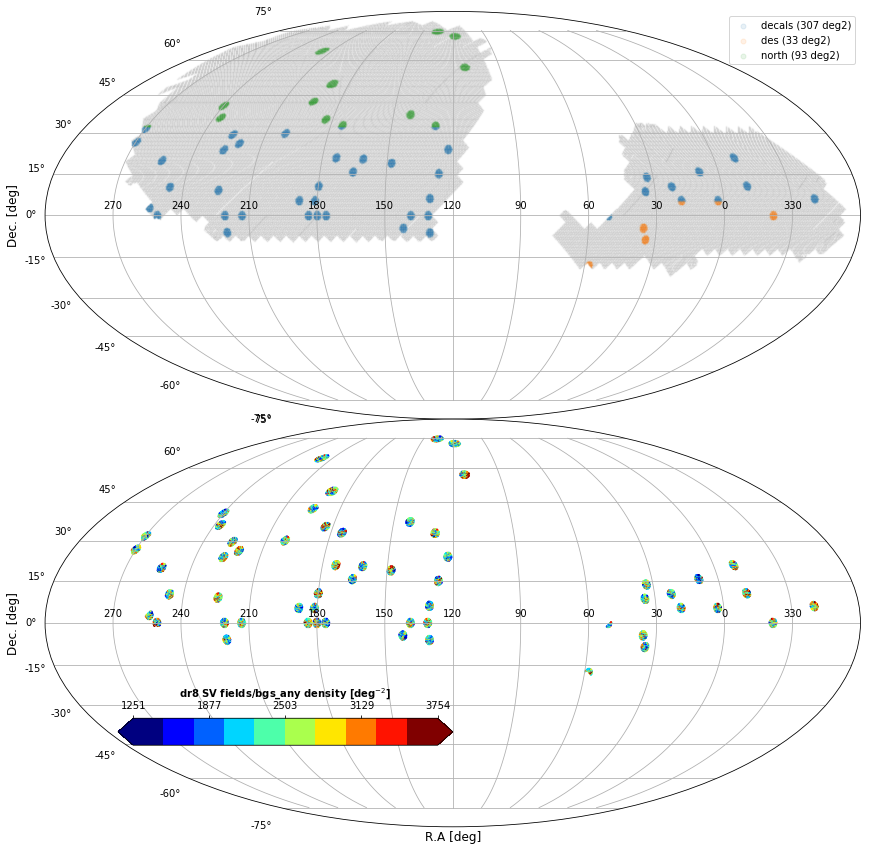

In [21]:
fig    = plt.figure(figsize=(20,15))
gs     = gridspec.GridSpec(2,1,wspace=0.15,hspace=0)

## plotting subregions
ax     = plt.subplot(gs[0],projection=projection)
_      = set_mwd(ax,org=org)
ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
tmp    = (hpdict['bgsfracarea']>0) & (hpdict['is'+'desi'])
ax.scatter(ramw[tmp][::2],decmw[tmp][::2],s=1,alpha=0.05, c='gray')
for reg in ['decals','des','north']:
    tmp    = (hpdict['bgsfracarea']>0) & (hpdict['is'+reg]) & (hpdict['isbgsfield'])
    SC = ax.scatter(ramw[tmp],decmw[tmp],s=1,alpha=0.1,
                    label=reg+' ('+'%.0f'%hpdict['bgsfield_area_'+reg]+' deg2)')
ax.legend(markerscale=5)

# mollweide
ax     = plt.subplot(gs[1],projection=projection)
_      = set_mwd(ax,org=org)
tmp    = (hpdict['bgsfracarea']>0) & (hpdict['isbgsfield'])
hpdens = (hpdict['south_n'+'any'] + hpdict['north_n'+'any'] ) / (pixarea * hpdict['bgsfracarea'])
SC  = ax.scatter(ramw[tmp],decmw[tmp],s=1,
c=hpdens[tmp],
cmap=cm,vmin=cmin,vmax=cmax,rasterized=True)
clab      = 'dr8 SV fields/'+'bgs_any'+r' density [deg$^{-2}$]'
hpmean = hpdict['meandens_svfields_any_all']
cmin,cmax = (0.5*hpmean,1.5*hpmean)
cbarticks = np.linspace(cmin,cmax,5)
cbar_ylab = ['%.0f' % x for x in cbarticks]
p  = ax.get_position().get_points().flatten()
cax= fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.2*(p[3]-p[1]),0.3*(p[2]-p[0]),0.025])
cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
cbar.set_label(clab,fontweight='bold')
cbar.ax.set_yticklabels(cbar_ylab)

plt.show()
plt.close()

In [17]:
#
def plot_denshist(namesel, mainreg, regs, meandensperfield=False, clip=True, labels=True, xlims=None):
    
    hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])
    
    if meandensperfield: x0 = np.array([np.nanmean(hpdens[(mainreg) & (tileid == i)]) for i in tiles['CENTERID']])
    else: x0 = hpdens[mainreg]
    
    if clip and (xlims is None): cmin, cmax = np.percentile(x0,(1,99))
    elif (~clip) and (xlims is not None): cmin, cmax = xlims[0], xlims[1]
    else: cmin, cmax = x0.min(), x0.max()
    #print(cmin, cmax)
    clab      = 'dr8/'+namesel+r' density [deg$^{-2}$]'
    
    # hist
    ax     = plt.subplot(gs[i])
    xgrid  = np.linspace(cmin,cmax,51)
    
    if labels: label=r'mean %s all (%2.f)' %(namesel, hpdict['meandens_'+namesel+'_all'])
    else: label = None
    
    ax.axvline(hpdict['meandens_svfields_'+namesel+'_all'], ls='--', lw=2, c='k',)
    ax.axvline(hpdict['meandens_'+namesel+'_all'], ls='--', lw=2, c='r', label=label)

    cols       = ['b','g','r']
    for reg,col in zip(regs,cols):
        
        if reg == 'all': 
            tmp2 = (mainreg)
            tmp3 = (hpdict['bgsfracarea']>0)
            histtype='stepfilled'
            alpha=0.3
            color='k'
        else: 
            tmp2 = (mainreg) & (hpdict['is'+reg])
            tmp3 = (hpdict['bgsfracarea']>0) & (hpdict['is'+reg])
            histtype='step'
            alpha=0.8
            color=col
        
        if meandensperfield: x = np.array([np.nanmean(hpdens[(tmp2) & (tileid == i)]) for i in tiles['CENTERID']])
        else: x = hpdens[tmp2]
            
        if labels: label='dr8/'+reg+' ('+'%.0f'%hpdict['meandens_svfields_'+namesel+'_'+reg]+')'
        else: label = None
        x2 = hpdens[tmp3]
            
        ax.hist(x2[np.isfinite(x2)], bins=xgrid,histtype='step',log=True, alpha=0.8,color=color,lw=2, ls='--', density=False)
        ax.hist(x[np.isfinite(x)], bins=xgrid,histtype=histtype,log=True, alpha=alpha,color=color,lw=2,density=False, label=label)
        
    ax.set_xlabel(clab,fontsize=15)
    if i == 0: ax.set_ylabel('counts',fontsize=15)
    ax.set_xlim(cmin,cmax)
    #ax.set_ylim(0,5)
    ax.grid(True)
    ax.legend()
    
#plt.show()
#plt.close()

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: Mean of empty slice
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


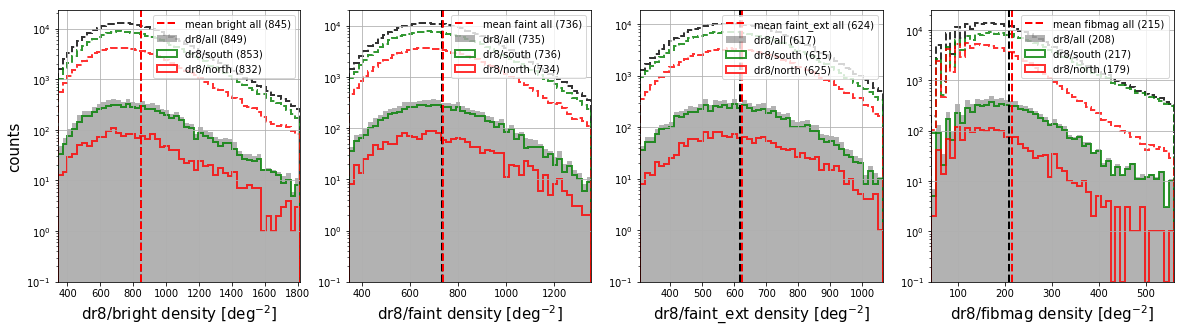

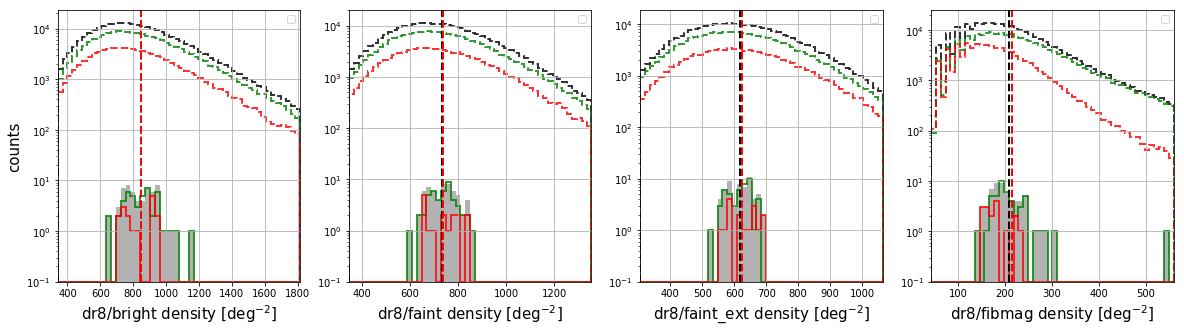

In [18]:
#
namesels = ['bright', 'faint', 'faint_ext', 'fibmag']
mainreg    = (hpdict['bgsfracarea']>0) & (hpdict['isbgsfield'])
regs       = ['all','south','north']
xlims = [[340.56, 1815.96], [346.43, 1354.65], [305.02, 1064.11], [42.43, 558.83]]

for k, j in enumerate([[regs, False, True, True], [regs, True, False, False]]):
    
    fig = plt.figure(figsize=(20,5))
    gs  = gridspec.GridSpec(1,4)

    for i, namesel in enumerate(namesels):
        
        if k == 0: xlim=None
        else: xlim=xlims[i]
        
        plot_denshist(namesel=namesel, mainreg=mainreg, regs=j[0], meandensperfield=j[1], clip=j[2], labels=j[3], xlims=xlim)
        
    #plt.show()
        

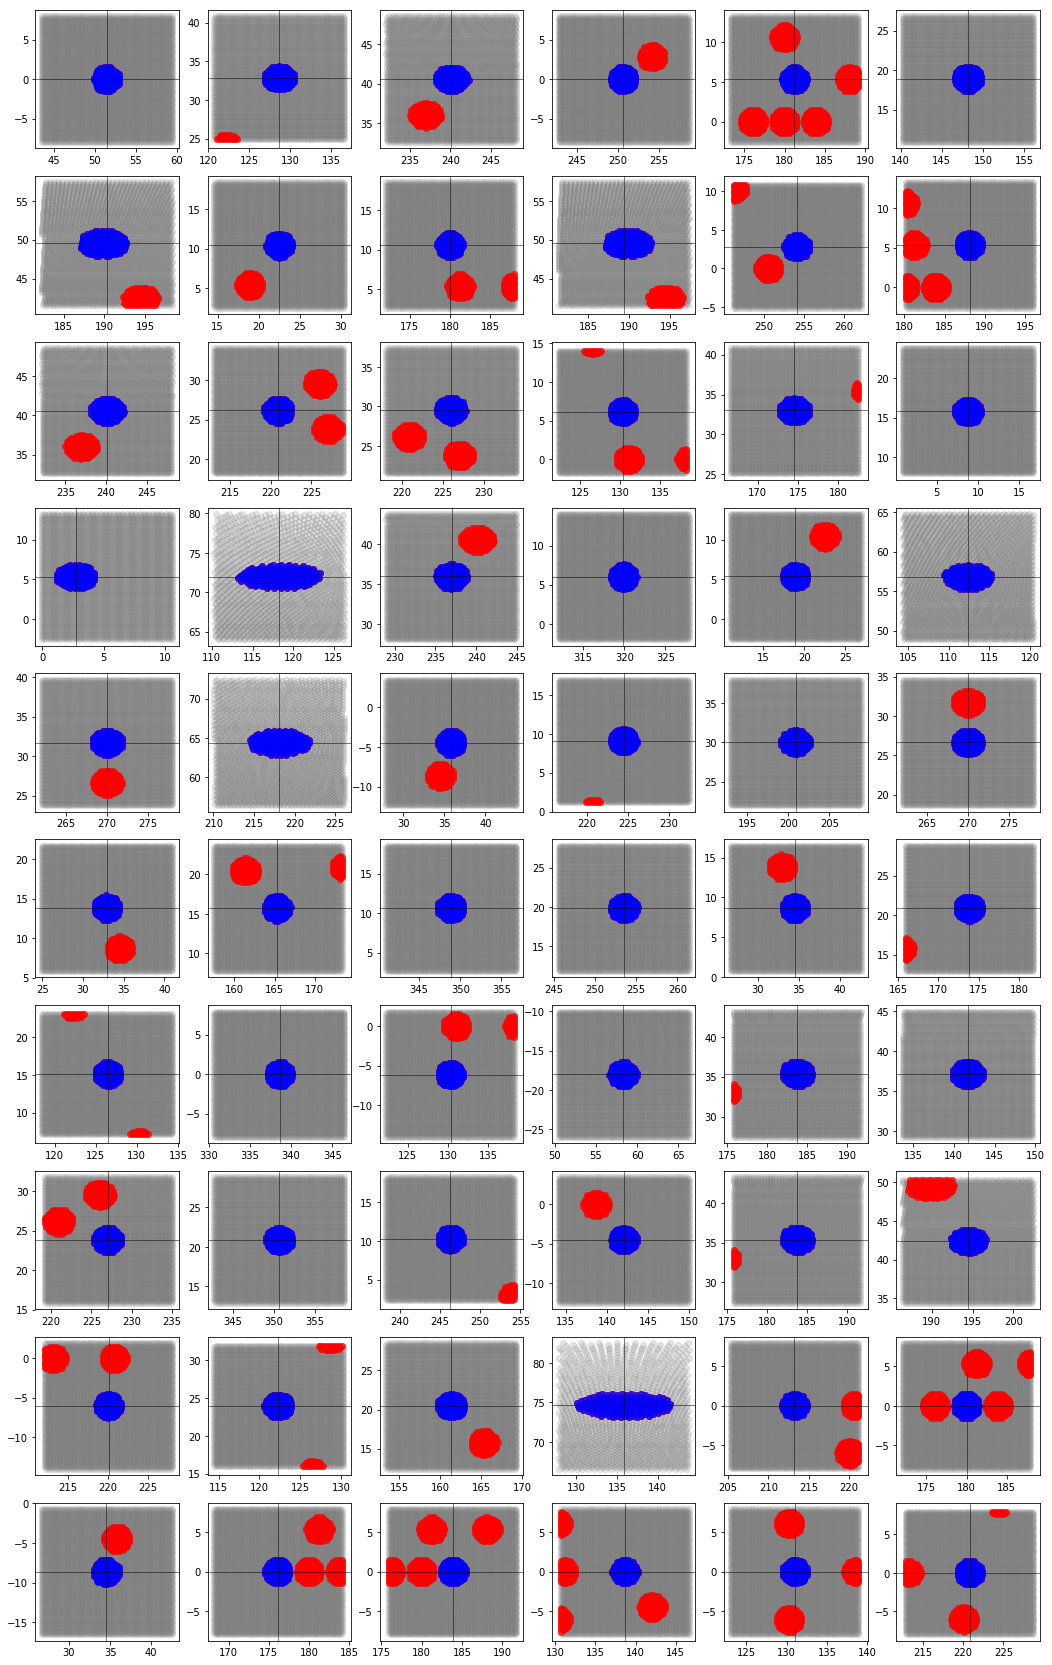

In [21]:
# sanity check of get_isbgstile output center id's
#n=31
plt.figure(figsize=(18, 30))
for n in range(len(tiles)):
    
    plt.subplot(10,6,n+1)
    x, y, ntile = tiles['RA'][n], tiles['DEC'][n], tiles['CENTERID'][n]
    w = 8
    mask = (hpdict['ra'] > x-w) & (hpdict['ra'] < x+w) & (hpdict['dec'] > y-w) & (hpdict['dec'] < y+w)
    mask2 = (hpdict['isbgsfield'])

    #plt.figure(figsize=(6,6))
    plt.scatter(hpdict['ra'][mask], hpdict['dec'][mask], c='gray', alpha=0.2) #hp positions within desifootprint
    plt.scatter(hpdict['ra'][mask & mask2], hpdict['dec'][mask & mask2], c='red', alpha=0.7) #hp positions within bgs sv fields
    plt.scatter(hpdict['ra'][tileid == ntile], hpdict['dec'][tileid == ntile], c='blue', alpha=0.7) #hp positions within each center id
    plt.axvline(x, lw=0.5, c='k')
    plt.axhline(y, lw=0.5, c='k')
    
    #plt.show()

# DEV ZONE

In [7]:
# creating dictionary
hpdict     = {}
theta,phi  = hp.pix2ang(nside,np.arange(npix),nest=nest)
hpdict['ra'],hpdict['dec'] = 180./np.pi*phi,90.-180./np.pi*theta
c          = SkyCoord(hpdict['ra']*units.degree,hpdict['dec']*units.degree, frame='icrs')
hpdict['gall'],hpdict['galb'] = c.galactic.l.value,c.galactic.b.value

# is in desi tile?
hpdict['isdesi'] = get_isdesi(hpdict['ra'],hpdict['dec'])

# propagating some keys from ADM pixweight
hdu        = fits.open(inptfiles['dr8pix'])
data       = hdu[1].data
for key in ['HPXPIXEL', 'FRACAREA', 
            'STARDENS', 'EBV', 
            'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z',
            'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z',
            'PSFDEPTH_W1', 'PSFDEPTH_W2',
            'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']:
    if (key=='STARDENS'):
        hpdict[key.lower()] = np.log10(data[key])
    elif (key[:8]=='GALDEPTH'):
        hpdict[key.lower()] = 22.5-2.5*np.log10(5./np.sqrt(data[key]))
    else:
        hpdict[key.lower()] = data[key]
        
# reading randoms to get bgs fraction area
# (using all rand files to minimize poisson noise in the area estimation)
# (however using only 1 rand file should also provide reasonable results; and be x10 faster)
data = get_random(N=Nranfiles, sweepsize=None, dr='dr8')
norig = len(data)
#cut in desi footprint
keep = get_isdesi(data['RA'],data['DEC'])
print('fraction of randoms in desi footprint %f' %(np.sum(keep)/len(data['RA'])))
# make cut in NOBS
keep &= (data['NOBS_G']>0) & (data['NOBS_R']>0) & (data['NOBS_Z']>0)
print('keeping ', len(data[keep]), '/', norig, 'after cutting on g+r+z')
# make cuts in maskbits
for bit in veto_maskbits:
    keep &= ((data['MASKBITS'] & 2**bit)==0)
print('keeping ', len(data[keep]), '/', norig, 'after cutting on g+r+z and maskbits')
randdens, ra, dec = 5000*Nranfiles, data['RA'][keep], data['DEC'][keep]
print('randdens = ', randdens, ' ; len randoms = ', len(ra))

# computing areas
hppix           = hp.ang2pix(nside,(90.-np.array(dec))*np.pi/180.,np.array(ra)*np.pi/180.,nest=nest)
ind,c           = np.unique(hppix,return_counts=True)
hpdict['bgsfracarea']      = np.zeros(npix)
hpdict['bgsfracarea'][ind] = c / randdens / pixarea

# north/south/des/decals
hpdict['issouth'] = np.zeros(npix,dtype=bool)
tmp               = (hpdict['bgsfracarea']>0) & ((hpdict['galb']<0) | ((hpdict['galb']>0) & (hpdict['dec']<dec_resol_ns)))
hpdict['issouth'][tmp] = True
hpdict['isnorth'] = np.zeros(npix,dtype=bool)
tmp               = (hpdict['bgsfracarea']>0) & (hpdict['dec']>dec_resol_ns) & (hpdict['galb']>0)
hpdict['isnorth'][tmp] = True
hpdict['isdes']   = raichoorlib.get_isdes(hpdict['ra'],hpdict['dec'])
hpdict['isdecals']= (hpdict['issouth']) & (~hpdict['isdes'])

# areas
hpdict['area_all']   = hpdict['bgsfracarea'].sum() * pixarea
for reg in ['south','decals','des','north']:
    hpdict['bgsarea_'+reg]   = hpdict['bgsfracarea'][hpdict['is'+reg]].sum() * pixarea 

1207 nearby objects


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in sqrt


RANDOM file already exist at:/global/cscratch1/sd/qmxp55/dr8_random_N3.npy
Total run time: 0.000932 sec
Weight of /global/cscratch1/sd/qmxp55/dr8_random_N3.npy catalogue: 6.82 GB
1207 nearby objects
fraction of randoms in desi footprint 0.701620
keeping  212901365 / 304987125 after cutting on g+r+z
keeping  207198209 / 304987125 after cutting on g+r+z and maskbits
randdens =  15000  ; len randoms =  207198209


In [ ]:
fns  = glob.glob(inptfiles['dr8randroot']+'*.fits')
fns = fns[0:Nranfiles]
## initialising
randdens,ra,dec = 0,[],[]
## looping on rand files
for fn in fns:
    print(fn.split('/')[-1])
    hdu  = fits.open(fn)
    data = hdu[1].data
    ## cutting on desi footprint
    data = data[get_isdesi(data['ra'],data['dec'])]
    norig = len(data)
    ## cut on g+r+z
    keep = (data['nobs_g']>0) & (data['nobs_r']>0) & (data['nobs_z']>0)
    print('keeping ', len(data[keep]), '/', norig, 'after cutting on g+r+z')
    ## cut on maskbits
    for bit in veto_maskbits:
        keep &= ((data['maskbits'] & 2**bit)==0)
    print('keeping ', len(data[keep]), '/', norig, 'after cutting on g+r+z and maskbits')
    data = data[keep]
    ## updating
    randdens += float(hdu[1].header['density'])
    ra       += data['ra'].tolist()
    dec      += data['dec'].tolist()
print('randdens = ', randdens, ' ; len(ra) = ', len(ra))

2019-10-18 07:49:03 start
plotting density distributions + systematics for the  bright selection


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


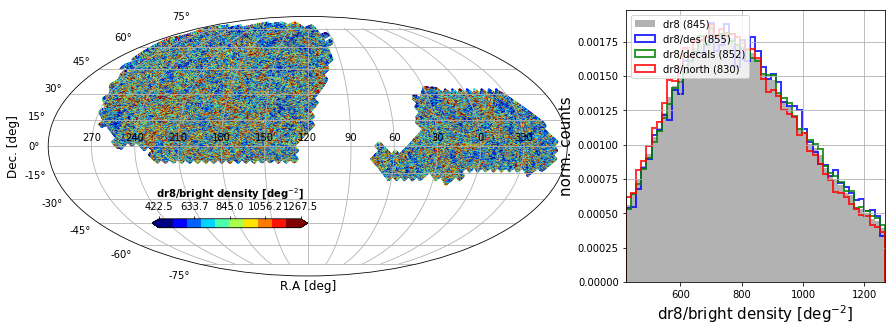

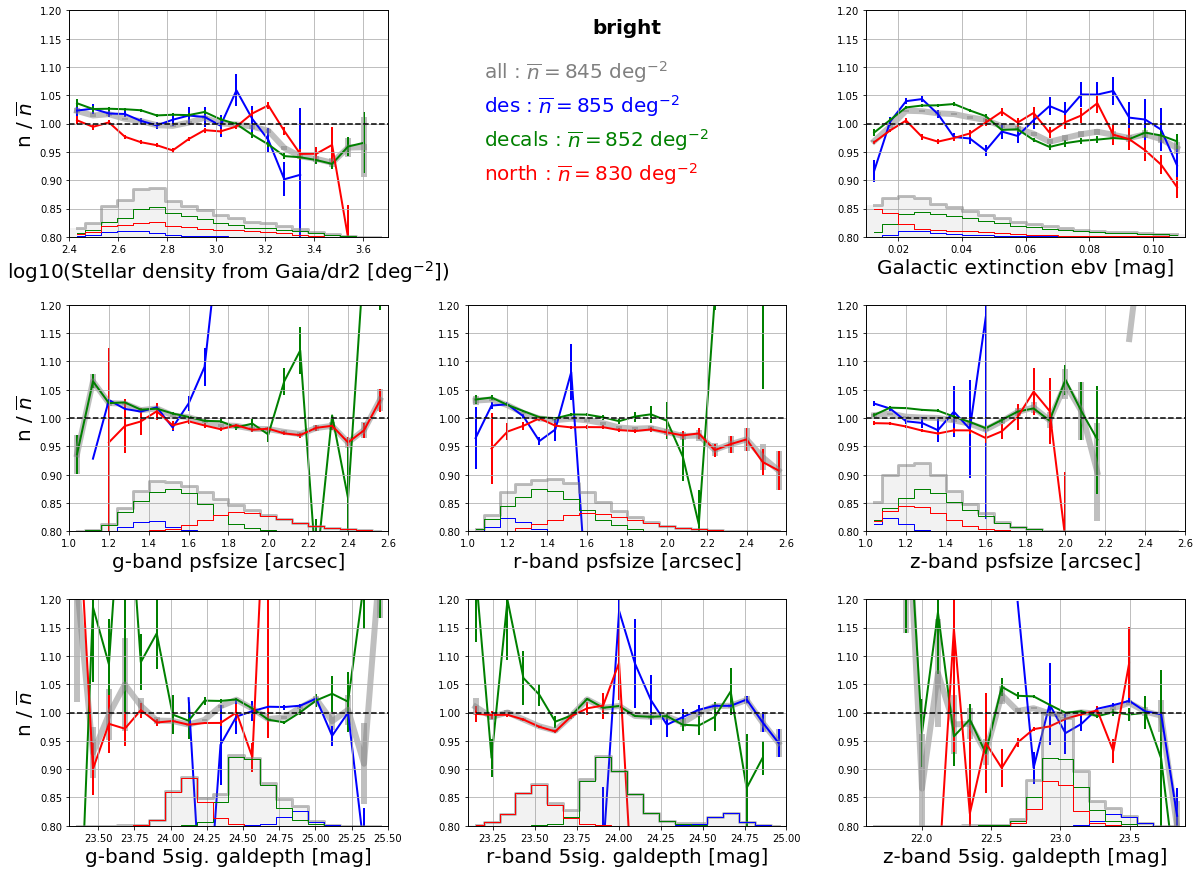



plotting density distributions + systematics for the  faint selection


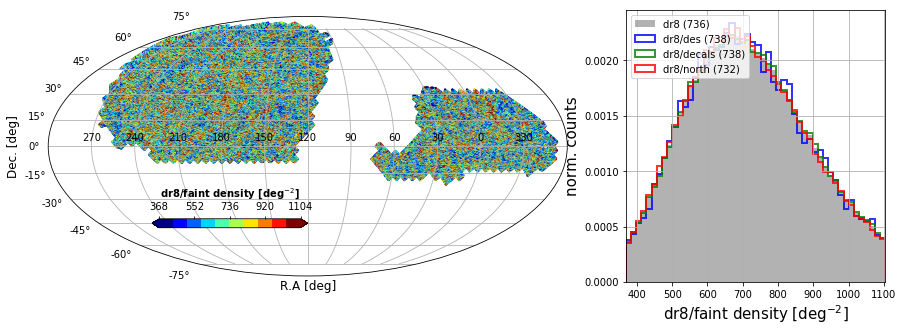

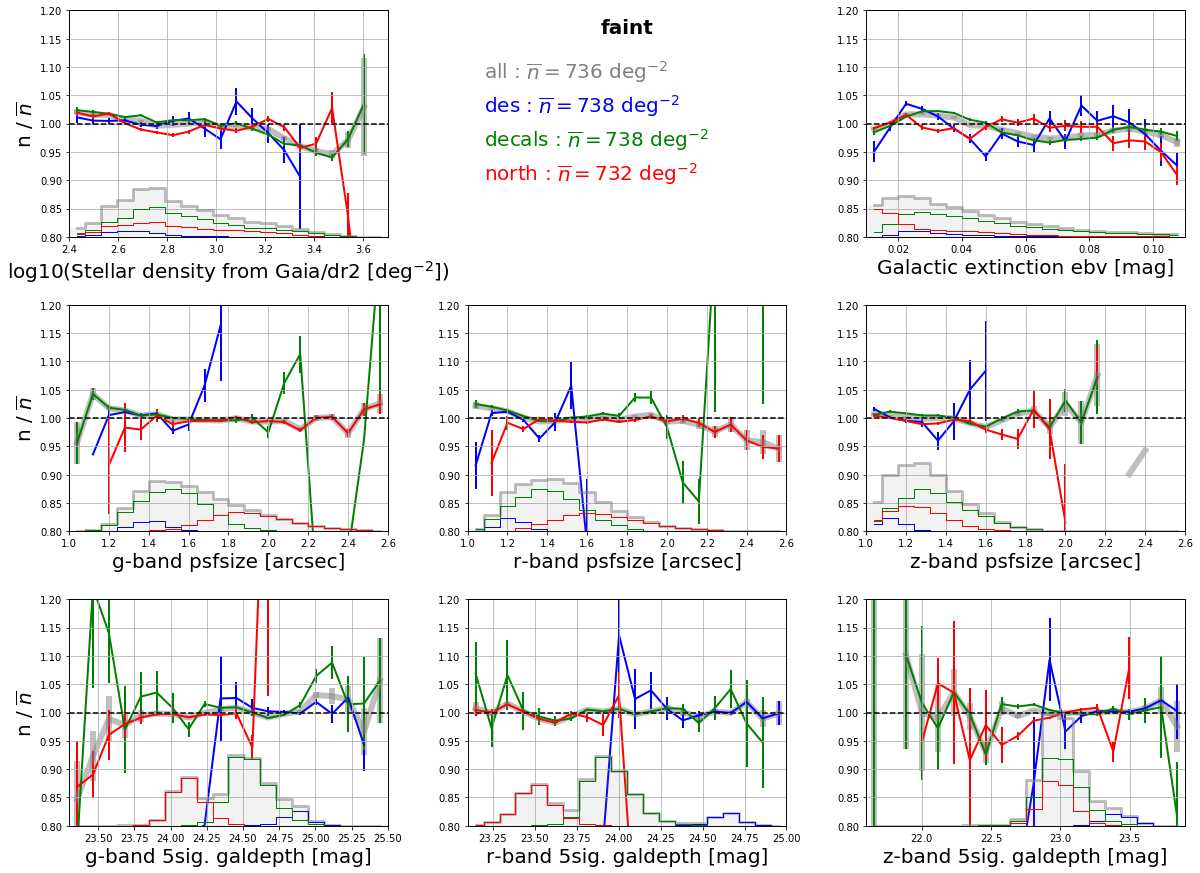



plotting density distributions + systematics for the  faint_ext selection


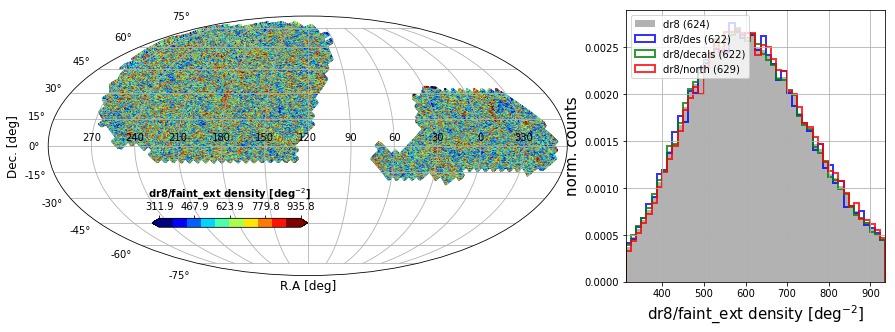

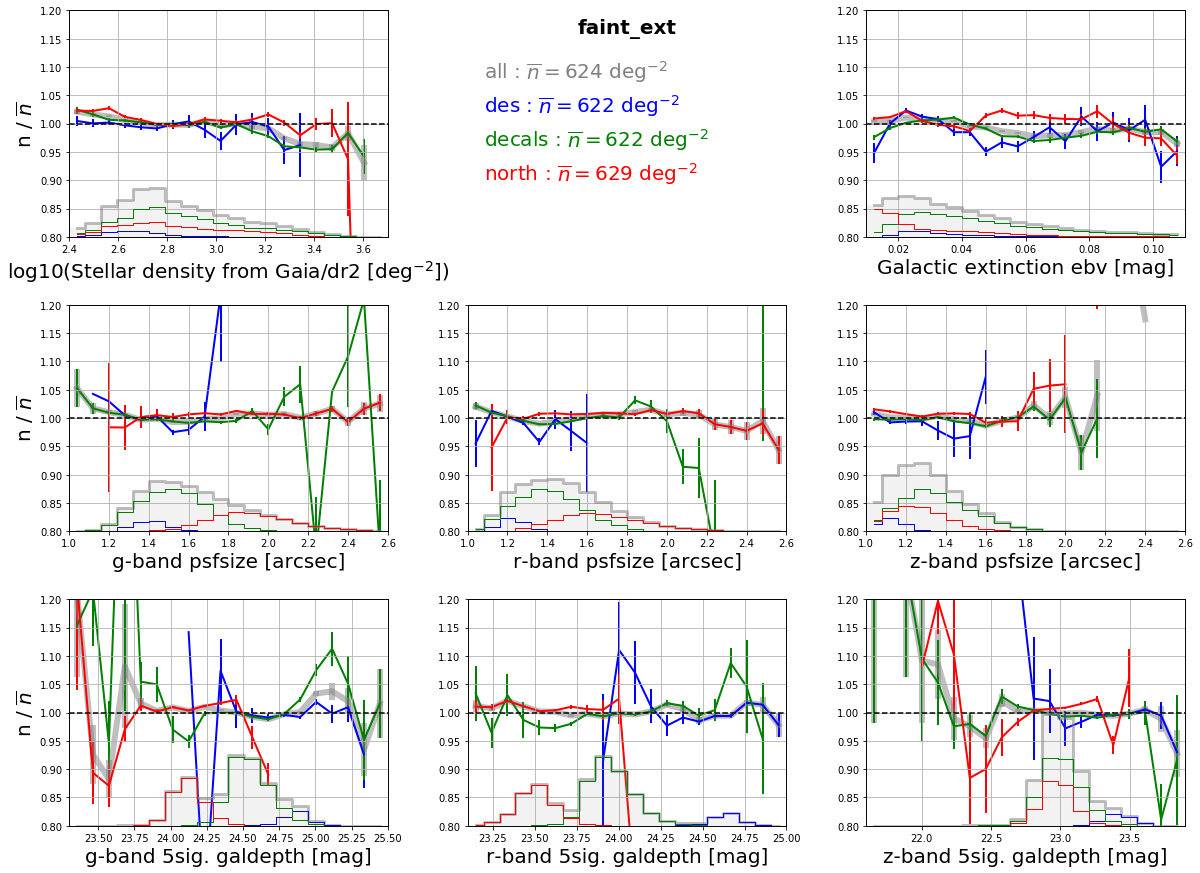



plotting density distributions + systematics for the  fibmag selection


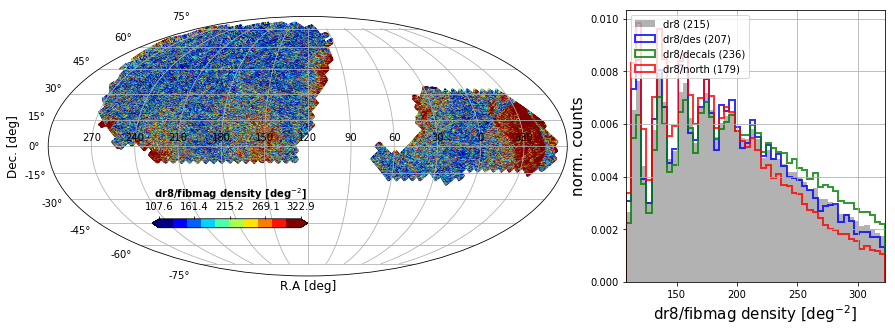

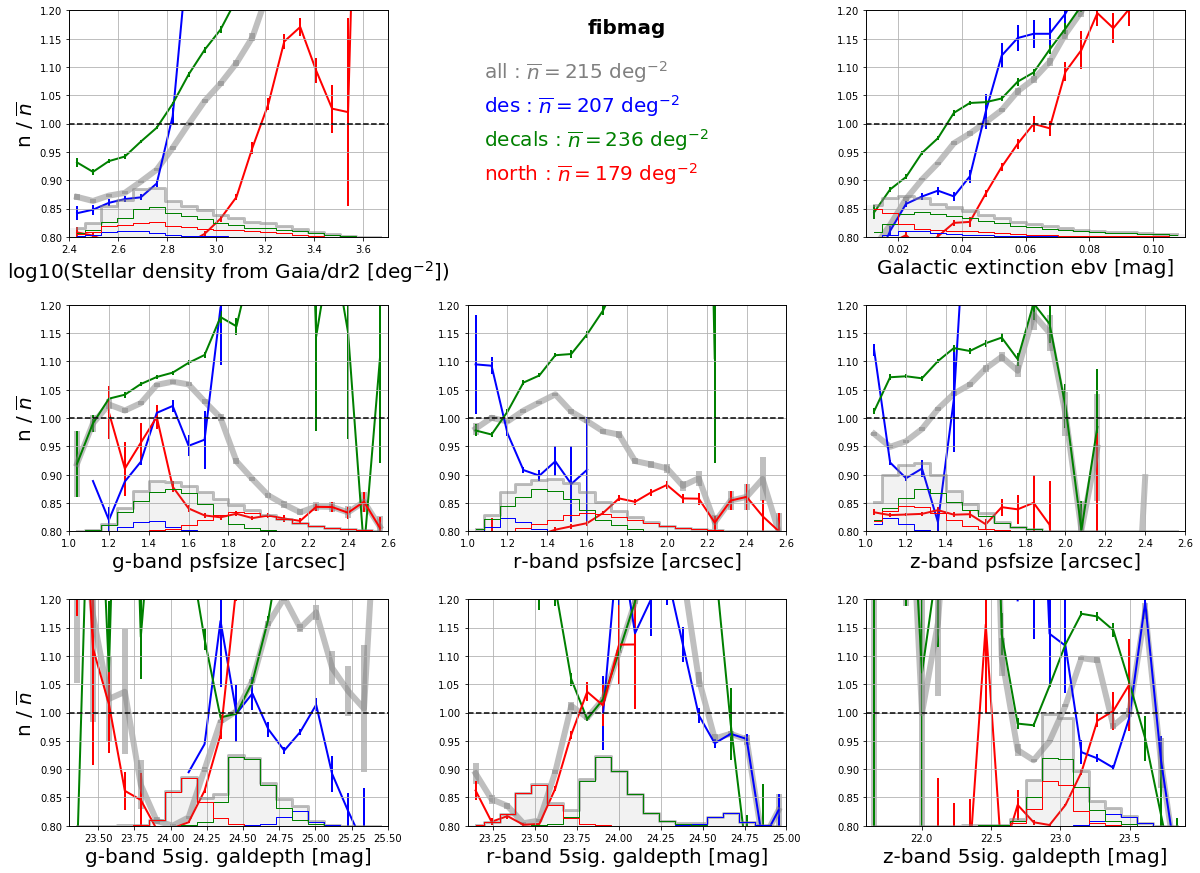



plotting density distributions + systematics for the  lowq selection


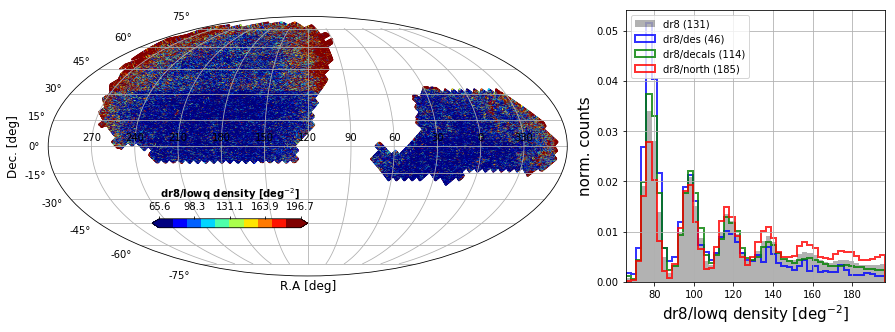

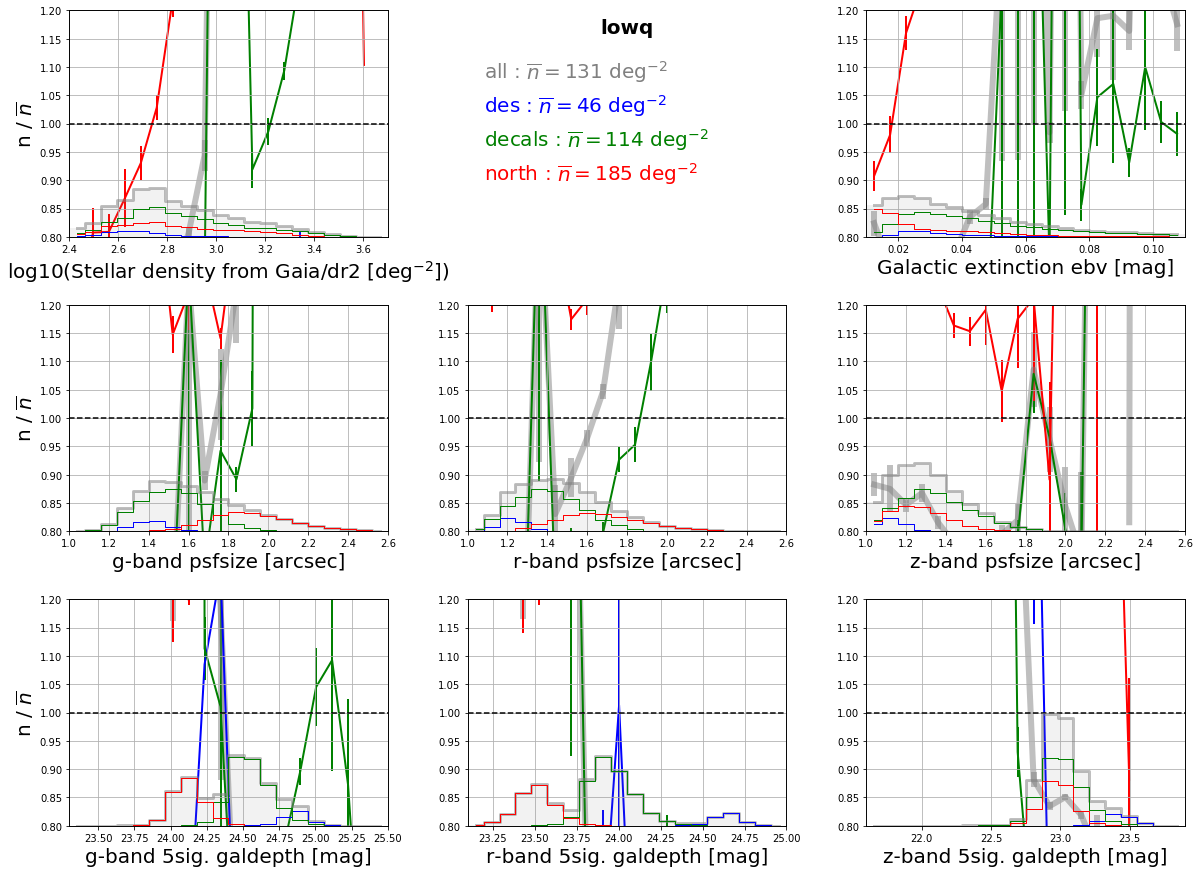



2019-10-18 07:49:49 end


In [10]:
# dr8_south+north : density distributions + systematics
print(raichoorlib.get_date(), 'start')

# subsamples (BGS SV supersets)
namesels = ['bright', 'faint', 'faint_ext', 'fibmag', 'lowq']
#namesels = ['bright']

# settings
ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
densmin,densmax = 0,2
regs       = ['all','des','decals','north']
cols       = ['0.5','b','g','r']

# looping on subselections
for namesel in namesels:
    
    print('plotting density distributions + systematics for the ', namesel, 'selection')
    
    hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])
    hpmean = hpdict['meandens_'+namesel+'_all']
    cmin,cmax = (0.5*hpmean,1.5*hpmean)
    cbarticks = np.linspace(cmin,cmax,5)
    cbar_ylab = ['%.0f' % x for x in cbarticks]
    clab      = 'dr8/'+namesel+r' density [deg$^{-2}$]'

    # density skymap + hist
    fig        = plt.figure(figsize=(15,5))
    gs         = gridspec.GridSpec(1,2,wspace=0.15,hspace=0.3,width_ratios=[2,1])
    # mollweide
    ax     = plt.subplot(gs[0],projection=projection)
    _      = set_mwd(ax,org=org)
    SC  = ax.scatter(ramw[isdesi],decmw[isdesi],s=1,
        c=hpdens[isdesi],
        cmap=cm,vmin=cmin,vmax=cmax,rasterized=True)
    p  = ax.get_position().get_points().flatten()
    cax= fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.2*(p[3]-p[1]),0.3*(p[2]-p[0]),0.025])
    cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
    cbar.set_label(clab,fontweight='bold')
    cbar.ax.set_yticklabels(cbar_ylab)
    # hist
    ax     = plt.subplot(gs[1])
    xgrid  = np.linspace(cmin,cmax,51)
    ax.hist(hpdens[isdesi],
            bins=xgrid,histtype='stepfilled',alpha=0.3,color='k',density=True,
            label='dr8 ('+'%.0f'%hpdict['meandens_'+namesel+'_all']+')')
    for reg,col in zip(regs[1:],cols[1:]):
        tmp    = (isdesi) & (hpdict['is'+reg])
        ax.hist(hpdens[tmp],
                bins=xgrid,histtype='step',alpha=0.8,color=col,lw=2,density=True,
                label='dr8/'+reg+' ('+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+')')
    ax.set_xlabel(clab,fontsize=15)
    ax.set_ylabel('norm. counts',fontsize=15)
    ax.set_xlim(cmin,cmax)
    #ax.set_ylim(0,5)
    ax.grid(True)
    ax.legend(ncol=1,loc=2)
    plt.show()
    plt.close()
            
    # systematics
    fig    = plt.figure(figsize=(20,15))
    gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
    for i in range(len(systs)):
        syst = systs[i]
        # plot/xlim settings
        xlim, xlabel = get_systplot(syst)
        tmpsyst = hpdict[syst][isdesi]
        #xlim = tmpsyst[tmpsyst > 0].min(), tmpsyst[tmpsyst > 0].max()
        #xlim = np.percentile(tmpsyst[tmpsyst>0],(1,99))
        xwidth = (xlim[1]-xlim[0])/nx
        # initializing plots
        if (i==0):
            ip = 0
        else:
            ip = 1+i
        if (i==1):
            axinfo = fig.add_subplot(gs[i])
        ax = fig.add_subplot(gs[ip])
        ## systematics
        ax.plot(xlim,[1.,1.],color='k',linestyle='--')
        ax.set_xlim(xlim)
        ax.set_ylim(0.8,1.2)
        ax.set_xlabel(xlabel,fontsize=20)
        if (ip%3==0):
            ax.set_ylabel(r'n / $\overline{n}$',fontsize=20)
        ax.grid(True)
        ## histogram
        axh = ax.twinx()
        axh.set_xlim(xlim)
        axh.set_ylim(0,8)
        axh.axes.get_yaxis().set_ticks([])
        ## systematics
        for reg,col in zip(regs,cols):
            if (reg=='all'):
                isreg    = (isdesi)
                lw,alpha = 3,0.5
            else:
                isreg    = (isdesi) & (hpdict['is'+reg])
                lw,alpha = 1,1.0
            tmpsyst   = hpdict[syst][isreg]
            #xlim      = tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))].min(), tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))].max()
            #xlim      = np.percentile(tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))],(1,99))
            tmpdens   = hpdens[isreg]
            #tmp       = ((tmpdens/hpdict['meandens_'+namesel+'_'+reg]>densmin) & 
            #             (tmpdens/hpdict['meandens_'+namesel+'_'+reg]<densmax) & 
            #             (tmpsyst>xlim[0]) & 
            #             (tmpsyst<xlim[1]))
            tmp       = (tmpsyst>xlim[0]) & (tmpsyst<xlim[1])
            systquant = tmpsyst[tmp]
            systdens  = tmpdens[tmp]
            #systdens /= hpdict['meandens_'+namesel+'_'+reg] #density/mean density per bit per region
            systdens /= hpdict['meandens_'+namesel+'_'+'all'] #density/mean density per bit overall desi footprint
            xgrid        = xlim[0]+np.arange(nx+1)/float(nx)*(xlim[1]-xlim[0])
            plotxgrid    = (xgrid[0:-1]+xgrid[1:])/2.
            systnobj     = np.ones(nx)*float('NaN')
            systv        = np.ones(nx)*float('NaN')
            systverr     = np.ones(nx)*float('NaN')
            for j in range(nx):
                tmp      = np.where((systquant >= xgrid[j]) & (systquant < xgrid[j+1]))[0]
                systnobj[j]= len(tmp)
                if (len(tmp) > 0):
                #if ((len(tmp)>0) & (xgrid[j+1]>systmin) & (xgrid[j]<systmax)):
                    #print ' ', xgrid[j] , xgrid[j+1], len(systquant[tmp]), np.mean(systdens[tmp])                
                    systv[j]   = np.mean(systdens[tmp])
                    systverr[j]= np.std (systdens[tmp])/np.sqrt(len(systdens[tmp]))
            tmpl  = 0.05*(xlim[1]-xlim[0])
            tmp = np.isfinite(systv)
            #print syst, t, np.average(systv[tmp],weights=systnobj[tmp]/np.sum(systnobj[tmp]))
            ax.errorbar(plotxgrid,systv,systverr,color=col,ecolor=col,zorder=1,lw=2*lw,alpha=alpha)
            # histogram
            height,_ = np.histogram(systquant,bins=xgrid)
            height   = height.astype(float) / 2.e4
            xcent    = 0.5*(xgrid[1:]+xgrid[:-1])
            if (reg=='all'):
                axh.bar(xcent,height,align='center',width=xwidth,alpha=0.1,color=col)
            axh.step(xcent,height,where='mid',alpha=alpha,lw=lw,color=col)
        # infos
        if (i==1):
            axinfo.axis('off')
            axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
            tmpy = 0.7
            for reg,col in zip(regs,cols):
                tmpstr = reg+' : '+r'$\overline{n}=$'+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
                axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=20,transform=axinfo.transAxes)
                tmpy  -= 0.15
    plt.show()
    plt.close()
    print('')
    print('')

print(raichoorlib.get_date(), 'end')